## Improving University Energy Efficiency:
# Building Energy Demand Prediction

Content:
1. Project Overview
2. Data Wrangling
3. Exploratory Analysis
4. Prediction using Different Machine Learning Methods
5. Summary
6. Conclusion
7. Discussion

Data access:

https://www.dropbox.com/s/ik42ibiyeqftkpo/Data.zip?dl=0


# 1. Project Overview

## Background and Motivation

The issue of energy performance of buildings is of great concern to building owners nowadays as it translates to cost. According to the U.S. Department of Energy, buildings consume about 40% of all energy used in the United States. Some states and municipalities have adopted energy savings targets for buildings in an effort to reduce air pollution and climate change in urban areas as well as regionally and globally.

In this project, we will apply machine learning methods to predict energy demand of buildings based on time, weather and historical data. This type of modeling is frequently applied to energy demand prediction for smart grid technologies and energy saving verification for building commissioning. In the past, Neural Networks were most commonly used for these tasks. We would like to apply more machine learning methods to such prediction.

## Related Work

We are not the first ones to conduct such studies. There are many papers out there regarding this topic. For example, 

Wu, Leon, et al. "Improving efficiency and reliability of building systems using machine learning and automated online evaluation." Systems, Applications and Technology Conference (LISAT), 2012 IEEE Long Island. IEEE, 2012.

We want to try different machine learning methods and implement the methods on an Harvard building.

## Project Objective / Initial Questions

<b>The main goal of this project is to use time and weather to predict energy demand of buildings based on historical data.</b> We are seeking easy-to-implement models with minimal input requirement and high accuracy. Such models will benefit managers of facilities, smart grid and building commissioning projects. <b>For university facilities, if they can predict the energy use of all campus buildings, they can make plans in advance to optimize the operations of chillers, boilers and energy storage systems.</b> The model will produce accurate energy demand forecasts that utility companies can use to decide the optimal amount of electricity to produce in the future and minimize cost. In building commissioning, engineers need to verify the energy savings after energy-saving measures have been implemented. However, it is difficult to have enough data points with the same conditions before and after the changes. Therefore, engineers need to interpolate and/or extrapolate the data. This is also an important application of this research.

We stick to this question through the entire project course. In our project proposal, we were thinking about testing our method on more buildings and doing some fault detection using the data. But the data cleaning part took longer than we thought. Therefore, we decided to focus on the prediction task on one building.



# 2. Data Wrangling

For some large scale buildings in Harvard, <b>there are three types energy consumption, electricity, chilled water and steam. Chilled water is for cooling and steam is for heating</b>. The following figure shows the buildings with chilled water and steam supply from Harvard plants.

<img src="Pics/cw and steam supply.png", style="width:100%">
<p align="center">Fig. Harvard chilled water and steam supply. (Left: chilled water, highlighted in blue. Right: Steam, highlighted in yellow.)</p>

We picked one building and got energy consumption data from 2011/07/01 to 2014/10/31. There are several months data missing due to meter malfunction. The data resolution is hourly. In original data, the hourly data is meter readings. So in order to get hourly consumption, we need to offset the data and do the minus. We have hourly data from January 2012 to October 2014 for both weather and energy (2.75 years). The weather data is from weather stations in Cambridge. 

---
In this section, we are going to finish the following tasks.

1. Get hourly electricity, chilled water and steam from the original data downloaded from Harvard Energy Witness website manually.

2. Clean weather data, add more features including cooling degrees, heating degress and humidity ratio.

3. Estimate daily occupancy based on holidays, school year and weekends.

4. Create features reletate to hour, which is cos(hourOfDay * 2 * pi / 24).

5. Merge electricity, chilled water and steam dataframe with weather and time and occupancy features.

In [1]:
%matplotlib inline 

import requests 
from StringIO import StringIO
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations
from __future__ import division
from math import log10,exp

pd.options.display.mpl_style = 'default'

## Original Energy Consumption Data

Original data are downloaded from <b>Harvard Energy Witness Website</b>
<img src="Pics/energyWitness1.png", style="width:80%">
<img src="Pics/energyWitness3.png", style="width:80%">

Then we use Pandas to put them together into one dataframe.


In [2]:
file = 'Data/Org/0701-0930-2011.xls' 
df = pd.read_excel(file, header = 0, skiprows = np.arange(0,6))

files = ['Data/Org/1101-1130-2011.xls', 'Data/Org/1201-2011-0131-2012.xls',
         'Data/Org/0201-0331-2012.xls','Data/Org/0401-0531-2012.xls','Data/Org/0601-0630-2012.xls',
         'Data/Org/0701-0831-2012.xls','Data/Org/0901-1031-2012.xls','Data/Org/1101-1231-2012.xls',
         'Data/Org/0101-0228-2013.xls',
         'Data/Org/0301-0430-2013.xls','Data/Org/0501-0630-2013.xls','Data/Org/0701-0831-2013.xls',
         'Data/Org/0901-1031-2013.xls','Data/Org/1101-1231-2013.xls','Data/Org/0101-0228-2014.xls',
         'Data/Org/0301-0430-2014.xls', 'Data/Org/0501-0630-2014.xls', 'Data/Org/0701-0831-2014.xls',
         'Data/Org/0901-1031-2014.xls']

for file in files:
    data = pd.read_excel(file, header = 0, skiprows = np.arange(0,6))
    df = df.append(data)

df.head()

WARNING *** file size (2481102) not 512 + multiple of sector size (512)
WARNING *** file size (848833) not 512 + multiple of sector size (512)
WARNING *** file size (1694257) not 512 + multiple of sector size (512)
WARNING *** file size (1640459) not 512 + multiple of sector size (512)
WARNING *** file size (1667907) not 512 + multiple of sector size (512)
WARNING *** file size (847258) not 512 + multiple of sector size (512)
WARNING *** file size (1691449) not 512 + multiple of sector size (512)
WARNING *** file size (1666647) not 512 + multiple of sector size (512)
WARNING *** file size (1665736) not 512 + multiple of sector size (512)
WARNING *** file size (1614814) not 512 + multiple of sector size (512)
WARNING *** file size (1665980) not 512 + multiple of sector size (512)
WARNING *** file size (1667276) not 512 + multiple of sector size (512)
WARNING *** file size (1691736) not 512 + multiple of sector size (512)
WARNING *** file size (1666704) not 512 + multiple of sector size 

Unnamed: 0 Unnamed: 1  Gund Bus-A 15 Min Block Demand - kW  \
0 2011-07-01 01:00:00      White                            48.458733   
1 2011-07-01 02:00:00      White                            40.472697   
2 2011-07-01 03:00:00    #d2e4b0                            39.472809   
3 2011-07-01 04:00:00      White                            39.198879   
4 2011-07-01 05:00:00      White                            39.297522   

   Gund Bus-A CurrentA - Amps  Unnamed: 4  Unnamed: 5  \
0                   65.977882         NaN         NaN   
1                   57.230223         NaN         NaN   
2                   55.487443         NaN         NaN   
3                   55.849806         NaN         NaN   
4                   55.736219         NaN         NaN   

   Gund Bus-A CurrentB - Amps  Unnamed: 7  Gund Bus-A CurrentC - Amps  \
0                   52.631417         NaN                   55.603840   
1                   42.483092         NaN                   50.243230   
2                   41.911784         NaN                   48.482163   
3                   41.525529         NaN                   48.987457   
4                   41.299381         NaN                   48.710408   

   Unnamed: 9              ...               Gund Main Demand - Tons  \
0         NaN              ...                              4.677294   
1         NaN              ...                              4.586403   
2         NaN              ...                              4.462877   
3         NaN              ...                              4.696993   
4         NaN              ...                              4.550372   

   Gund Main Energy - Ton-Days  Gund Main FlowRate - gpm  \
0                 17912.537804                  6.916454   
1                 17912.853518                  6.739337   
2                 17913.169232                  6.725142   
3                 17913.484946                  7.041330   
4                 17913.800660                  6.863004   

   Gund Main FlowTotal - kgal(1000)  Gund Main SignalAeration - Count  \
0                      48168.083414                          0.693405   
1                      48168.645429                          0.567355   
2                      48169.207444                          0.441304   
3                      48169.769458                          0.315254   
4                      48170.331473                          0.189204   

   Gund Main SignalStrength - Count  Gund Main SonicVelocity - Ft/Sec  \
0                         57.208127                       1437.640543   
1                         57.082909                       1438.030719   
2                         57.001646                       1439.111130   
3                         57.000000                       1440.768604   
4                         57.000000                       1442.426077   

   Gund Main TempDelta - Deg F  Gund Main TempReturn - Deg F  \
0                    16.238684                     59.757447   
1                    16.263573                     59.710199   
2                    15.797043                     59.248158   
3                    15.947392                     59.207097   
4                    15.903679                     59.282707   

   Gund Main TempSupply - Deg F  
0                     43.516103  
1                     43.495128  
2                     43.457344  
3                     43.267682  
4                     43.372615  

[5 rows x 55 columns]

> Above is the original hourly data.

As you can see, it is quite messy. The first thing to remove meaningless columns.

In [3]:
df.rename(columns={'Unnamed: 0':'Datetime'}, inplace=True)
nonBlankColumns = ['Unnamed' not in s for s in df.columns]
columns = df.columns[nonBlankColumns]
df = df[columns]
df = df.set_index(['Datetime'])
df.index.name = None
df.head()

Gund Bus-A 15 Min Block Demand - kW  \
2011-07-01 01:00:00                            48.458733   
2011-07-01 02:00:00                            40.472697   
2011-07-01 03:00:00                            39.472809   
2011-07-01 04:00:00                            39.198879   
2011-07-01 05:00:00                            39.297522   

                     Gund Bus-A CurrentA - Amps  Gund Bus-A CurrentB - Amps  \
2011-07-01 01:00:00                   65.977882                   52.631417   
2011-07-01 02:00:00                   57.230223                   42.483092   
2011-07-01 03:00:00                   55.487443                   41.911784   
2011-07-01 04:00:00                   55.849806                   41.525529   
2011-07-01 05:00:00                   55.736219                   41.299381   

                     Gund Bus-A CurrentC - Amps  Gund Bus-A CurrentN - Amps  \
2011-07-01 01:00:00                   55.603840                   15.982278   
2011-07-01 02:00:00                   50.243230                   13.423762   
2011-07-01 03:00:00                   48.482163                   13.478933   
2011-07-01 04:00:00                   48.987457                   13.603309   
2011-07-01 05:00:00                   48.710408                   13.797331   

                     Gund Bus-A EnergyReal - kWhr  Gund Bus-A Freq - Hertz  \
2011-07-01 01:00:00                1796757.502803                59.837524   
2011-07-01 02:00:00                1796800.145991                60.005569   
2011-07-01 03:00:00                1796840.146023                59.833880   
2011-07-01 04:00:00                1796879.023607                59.673044   
2011-07-01 05:00:00                1796918.273558                59.986672   

                     Gund Bus-A Max Monthly Demand - kW  \
2011-07-01 01:00:00                           96.117915   
2011-07-01 02:00:00                           96.117915   
2011-07-01 03:00:00                           96.117915   
2011-07-01 04:00:00                           96.117915   
2011-07-01 05:00:00                           96.117915   

                     Gund Bus-A PowerApp - kVA  Gund Bus-A PowerReac - kVAR  \
2011-07-01 01:00:00                  48.757073                    12.344712   
2011-07-01 02:00:00                  42.238685                    12.967984   
2011-07-01 03:00:00                  41.278573                    12.732046   
2011-07-01 04:00:00                  41.345776                    12.687845   
2011-07-01 05:00:00                  41.166736                    12.437842   

                                 ...               Gund Main Demand - Tons  \
2011-07-01 01:00:00              ...                              4.677294   
2011-07-01 02:00:00              ...                              4.586403   
2011-07-01 03:00:00              ...                              4.462877   
2011-07-01 04:00:00              ...                              4.696993   
2011-07-01 05:00:00              ...                              4.550372   

                     Gund Main Energy - Ton-Days  Gund Main FlowRate - gpm  \
2011-07-01 01:00:00                 17912.537804                  6.916454   
2011-07-01 02:00:00                 17912.853518                  6.739337   
2011-07-01 03:00:00                 17913.169232                  6.725142   
2011-07-01 04:00:00                 17913.484946                  7.041330   
2011-07-01 05:00:00                 17913.800660                  6.863004   

                     Gund Main FlowTotal - kgal(1000)  \
2011-07-01 01:00:00                      48168.083414   
2011-07-01 02:00:00                      48168.645429   
2011-07-01 03:00:00                      48169.207444   
2011-07-01 04:00:00                      48169.769458   
2011-07-01 05:00:00                      48170.331473   

                     Gund Main SignalAeration - Count  \
2011-07-01 01:00:00                          0.693405   
2011-07-01 02:00

Then we print out all the column names. Only a few columns are useful to get the hourly electricity, chilled water and steam.

In [4]:
for item in df.columns:
    print item

Gund Bus-A 15 Min Block Demand - kW
Gund Bus-A CurrentA - Amps
Gund Bus-A CurrentB - Amps
Gund Bus-A CurrentC - Amps
Gund Bus-A CurrentN - Amps
Gund Bus-A EnergyReal - kWhr
Gund Bus-A Freq - Hertz
Gund Bus-A Max Monthly Demand - kW
Gund Bus-A PowerApp - kVA
Gund Bus-A PowerReac - kVAR
Gund Bus-A PowerReal - kW
Gund Bus-A TruePF - PF
Gund Bus-A VoltageAB - Volts
Gund Bus-A VoltageAN - Volts
Gund Bus-A VoltageBC - Volts
Gund Bus-A VoltageBN - Volts
Gund Bus-A VoltageCA - Volts
Gund Bus-A VoltageCN - Volts
Gund Bus-B 15 Min Block Demand - kW
Gund Bus-B CurrentA - Amps
Gund Bus-B CurrentB - Amps
Gund Bus-B CurrentC - Amps
Gund Bus-B CurrentN - Amps
Gund Bus-B EnergyReal - kWhr
Gund Bus-B Freq - Hertz
Gund Bus-B Max Monthly Demand - kW
Gund Bus-B PowerApp - kVA
Gund Bus-B PowerReac - kVAR
Gund Bus-B PowerReal - kW
Gund Bus-B TruePF - PF
Gund Bus-B VoltageAB - Volts
Gund Bus-B VoltageAN - Volts
Gund Bus-B VoltageBC - Volts
Gund Bus-B VoltageBN - Volts
Gund Bus-B VoltageCA - Volts
Gund Bus-B 

## Electricity
Use electricity as an example, there are two meters, "Gund Bus A" and "Gund Bus B". The "EnergyReal - kWhr" records accumulative consumption. We are not sure exactly what is "PowerReal". Just in case, we put it into the electricity dateframe as well.

In [5]:
electricity=df[['Gund Bus-A EnergyReal - kWhr','Gund Bus-B EnergyReal - kWhr',
                'Gund Bus-A PowerReal - kW','Gund Bus-B PowerReal - kW',]]
electricity.head()

Gund Bus-A EnergyReal - kWhr  \
2011-07-01 01:00:00                1796757.502803   
2011-07-01 02:00:00                1796800.145991   
2011-07-01 03:00:00                1796840.146023   
2011-07-01 04:00:00                1796879.023607   
2011-07-01 05:00:00                1796918.273558   

                     Gund Bus-B EnergyReal - kWhr  Gund Bus-A PowerReal - kW  \
2011-07-01 01:00:00                3657811.582122                  47.184015   
2011-07-01 02:00:00                3657873.464938                  40.208796   
2011-07-01 03:00:00                3657934.837505                  39.209866   
2011-07-01 04:00:00                3657995.470348                  39.378507   
2011-07-01 05:00:00                3658054.470285                  39.240837   

                     Gund Bus-B PowerReal - kW  
2011-07-01 01:00:00                  63.486186  
2011-07-01 02:00:00                  61.270542  
2011-07-01 03:00:00                  61.464394  
2011-07-01 04:00:00                  59.396581  
2011-07-01 05:00:00                  58.911729

### Validate our data processing method by checking monthly energy consumption

In order to check whether our understanding of the data is correct, we want to calculate monthly electricity consumption from the hourly data, and then compare the results with the monthly data provided by facalities, which is available on Energy Witness as well.

> Here is the monthly data provided by facalities, "Bus A & B" are called "CE603B kWh" and "CE604B kWh" in ths monthly form. They are simply two meters. Please note, the meter reading cycle is NOT calendar month.


In [6]:
file = 'Data/monthly electricity.csv' 
monthlyElectricityFromFacility = pd.read_csv(file, header=0)
monthlyElectricityFromFacility
monthlyElectricityFromFacility = monthlyElectricityFromFacility.set_index(['month'])
monthlyElectricityFromFacility.head()

startDate   endDate  CE603B kWh  CE604B kWh
month                                             
Jul 11   6/16/11   7/18/11     43968.1    106307.1
Aug 11   7/18/11   8/17/11     41270.1     83121.1
Sep 11   8/17/11   9/16/11     51514.1    107083.1
Oct 11   9/16/11  10/18/11     65338.1    114350.1
Nov 11  10/18/11  11/17/11     65453.1    115318.1

We use the column "EnergyReal - kWhr" for two meters. We found the numbers of the begin and end date of the meter reading cycle, and use the number of the end date minus the number of the begin date, then we get our monthly electiricty consumption.


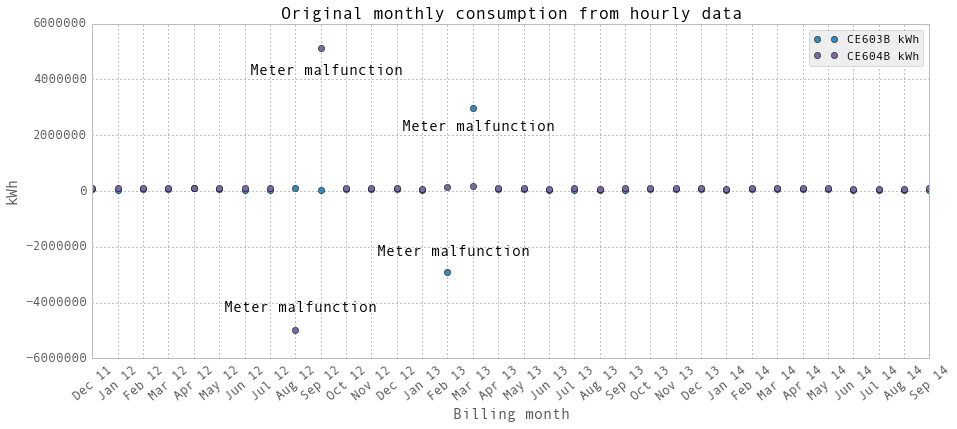

In [7]:
monthlyElectricityFromFacility['startDate'] = pd.to_datetime(monthlyElectricityFromFacility['startDate'], format="%m/%d/%y")
values = monthlyElectricityFromFacility.index.values

keys = np.array(monthlyElectricityFromFacility['startDate'])

dates = {}
for key, value in zip(keys, values):
    dates[key] = value

sortedDates =  np.sort(dates.keys())
sortedDates = sortedDates[sortedDates > np.datetime64('2011-11-01')]

months = []
monthlyElectricityOrg = np.zeros((len(sortedDates) - 1, 2))
for i in range(len(sortedDates) - 1):
    begin = sortedDates[i]
    end = sortedDates[i+1]
    months.append(dates[sortedDates[i]])
    monthlyElectricityOrg[i, 0] = (np.round(electricity.loc[end,'Gund Bus-A EnergyReal - kWhr'] 
                           -  electricity.loc[begin,'Gund Bus-A EnergyReal - kWhr'], 1))
    monthlyElectricityOrg[i, 1] = (np.round(electricity.loc[end,'Gund Bus-B EnergyReal - kWhr'] 
                           -  electricity.loc[begin,'Gund Bus-B EnergyReal - kWhr'], 1))

monthlyElectricity = pd.DataFrame(data = monthlyElectricityOrg, index = months, columns = ['CE603B kWh', 'CE604B kWh'])


plt.figure()
fig, ax = plt.subplots()
fig = monthlyElectricity.plot(marker = 'o', figsize=(15,6), rot = 40, fontsize = 13, ax = ax, linestyle='')
fig.set_axis_bgcolor('w')
plt.xlabel('Billing month', fontsize = 15)
plt.ylabel('kWh', fontsize = 15)
plt.tick_params(which=u'major', reset=False, axis = 'y', labelsize = 13)
plt.xticks(np.arange(0,len(months)),months)
plt.title('Original monthly consumption from hourly data',fontsize = 17)

text = 'Meter malfunction'
ax.annotate(text, xy = (9, 4500000), 
            xytext = (5, 2), fontsize = 15,
            textcoords = 'offset points', ha = 'center', va = 'top')

ax.annotate(text, xy = (8, -4500000), 
            xytext = (5, 2), fontsize = 15, 
            textcoords = 'offset points', ha = 'center', va = 'bottom')

ax.annotate(text, xy = (14, -2500000), 
            xytext = (5, 2), fontsize = 15, 
            textcoords = 'offset points', ha = 'center', va = 'bottom')

ax.annotate(text, xy = (15, 2500000), 
            xytext = (5, 2), fontsize = 15, 
            textcoords = 'offset points', ha = 'center', va = 'top')

plt.show()


> Above is a plot of monthly electricity consumption using our data processing method. Obviously, the two meters malfunctioned for several months. There are two sets of dots "CE603B" and "CE604B", which come from two meters. There are two electricity meters. The sum of them is the total electricity consumption of the building.

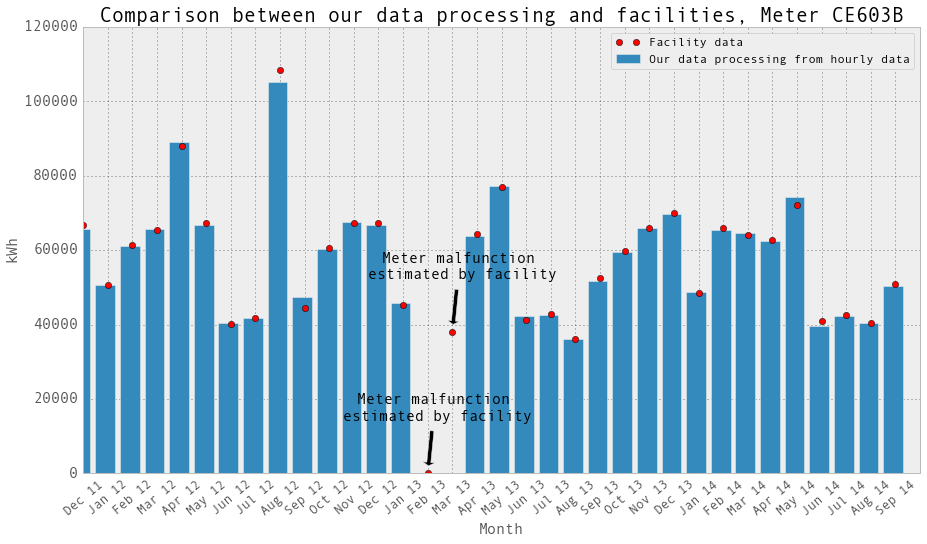

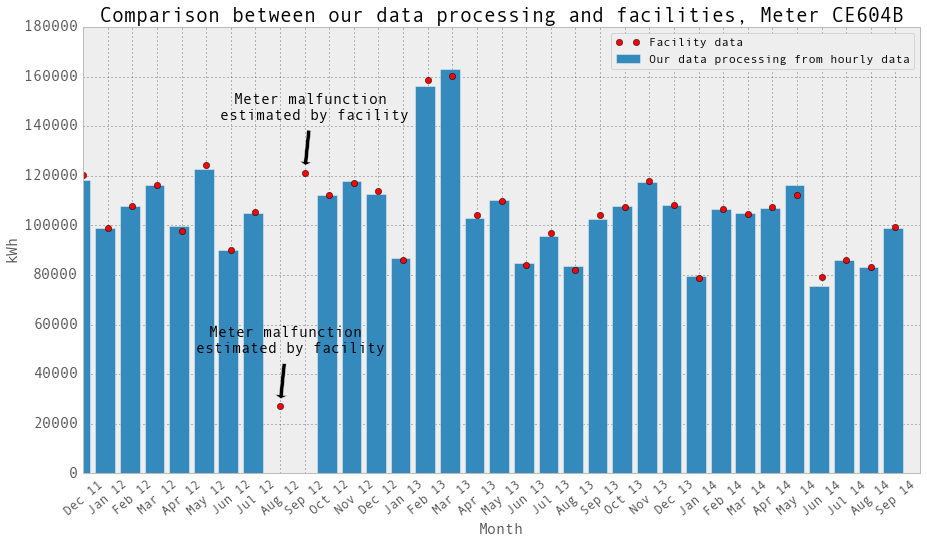

In [53]:
monthlyElectricity.loc['Aug 12','CE604B kWh'] = np.nan
monthlyElectricity.loc['Sep 12','CE604B kWh'] = np.nan
monthlyElectricity.loc['Feb 13','CE603B kWh'] = np.nan
monthlyElectricity.loc['Mar 13','CE603B kWh'] = np.nan


fig,ax = plt.subplots(1, 1,figsize=(15,8))
#ax.set_axis_bgcolor('w')
plt.bar(np.arange(0, len(monthlyElectricity))-0.5,monthlyElectricity['CE603B kWh'], label='Our data processing from hourly data')
plt.plot(monthlyElectricityFromFacility.loc[months,'CE603B kWh'],'or', label='Facility data')
plt.xticks(np.arange(0,len(months)),months)
plt.xlabel('Month',fontsize=15)
plt.ylabel('kWh',fontsize=15)
plt.xlim([0, len(monthlyElectricity)])
plt.legend()
ax.set_xticklabels(months, rotation=40, fontsize=13)
plt.tick_params(which=u'major', reset=False, axis = 'y', labelsize = 15)
plt.title('Comparison between our data processing and facilities, Meter CE603B',fontsize=20)

text = 'Meter malfunction \n estimated by facility'
ax.annotate(text, xy = (14, monthlyElectricityFromFacility.loc['Feb 13','CE603B kWh']), 
            xytext = (5, 50), fontsize = 15, 
            arrowprops=dict(facecolor='black', shrink=0.15),
            textcoords = 'offset points', ha = 'center', va = 'bottom')

ax.annotate(text, xy = (15, monthlyElectricityFromFacility.loc['Mar 13','CE603B kWh']), 
            xytext = (5, 50), fontsize = 15, 
            arrowprops=dict(facecolor='black', shrink=0.15),
            textcoords = 'offset points', ha = 'center', va = 'bottom')
plt.show()

fig,ax = plt.subplots(1, 1,figsize=(15,8))
#ax.set_axis_bgcolor('w')
plt.bar(np.arange(0, len(monthlyElectricity))-0.5, monthlyElectricity['CE604B kWh'], label='Our data processing from hourly data')
plt.plot(monthlyElectricityFromFacility.loc[months,'CE604B kWh'],'or', label='Facility data')
plt.xticks(np.arange(0,len(months)),months)
plt.xlabel('Month',fontsize=15)
plt.ylabel('kWh',fontsize=15)
plt.xlim([0, len(monthlyElectricity)])
plt.legend()
ax.set_xticklabels(months, rotation=40, fontsize=13)
plt.tick_params(which=u'major', reset=False, axis = 'y', labelsize = 15)
plt.title('Comparison between our data processing and facilities, Meter CE604B',fontsize=20)


ax.annotate(text, xy = (9, monthlyElectricityFromFacility.loc['Sep 12','CE604B kWh']), 
            xytext = (5, 50), fontsize = 15, 
            arrowprops=dict(facecolor='black', shrink=0.15),
            textcoords = 'offset points', ha = 'center', va = 'bottom')

ax.annotate(text, xy = (8, monthlyElectricityFromFacility.loc['Aug 12','CE604B kWh']), 
            xytext = (5, 50), fontsize = 15, 
            arrowprops=dict(facecolor='black', shrink=0.15),
            textcoords = 'offset points', ha = 'center', va = 'bottom')
plt.show()


The dots in the picture are monthly data provided by facility. They are the numbers on a bill. When meters were malfunctioning, the facility just estimated the energy use for billin purpose. The data points we excluded are not in the plot. They are simply way higher than normal (30 times more than other normal consumption). "Meter malfunction, estimated by facility" means in this month, the meter was malfunctioning and this dot is what facilities estimated. 

Meter "CE603B" malfunctioned on February and March 2013. Meter "CE604B" malfunctioned on August and September 2012. We set the nubmers of these months to np.nan and simply exclude them from regression. Plot them againa and compare with the facility monthly data. <b>They match!</b> Of course, excep when the meters were malfunctioning. In thoses months, the facilities estimated the energy consumption for billing purpose. For us, we just excluded hourly and daily data points during thoese months in regression. 

The total building electricity consumption is the sum of these two meters. Just in case, we keep the "power" and compare them with "energy"

In [54]:
electricity['energy'] = electricity['Gund Bus-A EnergyReal - kWhr'] + electricity['Gund Bus-B EnergyReal - kWhr']
electricity['power'] = electricity['Gund Bus-A PowerReal - kW'] + electricity['Gund Bus-B PowerReal - kW']
electricity.head()

Gund Bus-A EnergyReal - kWhr  \
2011-07-01 00:00:00                           NaN   
2011-07-01 01:00:00                1796757.502803   
2011-07-01 02:00:00                1796800.145991   
2011-07-01 03:00:00                1796840.146023   
2011-07-01 04:00:00                1796879.023607   

                     Gund Bus-B EnergyReal - kWhr  Gund Bus-A PowerReal - kW  \
2011-07-01 00:00:00                           NaN                        NaN   
2011-07-01 01:00:00                3657811.582122                  47.184015   
2011-07-01 02:00:00                3657873.464938                  40.208796   
2011-07-01 03:00:00                3657934.837505                  39.209866   
2011-07-01 04:00:00                3657995.470348                  39.378507   

                     Gund Bus-B PowerReal - kW          energy       power  \
2011-07-01 00:00:00                        NaN             NaN         NaN   
2011-07-01 01:00:00                  63.486186  5454569.084925  110.670201   
2011-07-01 02:00:00                  61.270542  5454673.610929  101.479338   
2011-07-01 03:00:00                  61.464394  5454774.983528  100.674260   
2011-07-01 04:00:00                  59.396581  5454874.493955   98.775088   

                              startTime             endTime  
2011-07-01 00:00:00 2011-07-01 00:00:00 2011-07-01 01:00:00  
2011-07-01 01:00:00 2011-07-01 01:00:00 2011-07-01 02:00:00  
2011-07-01 02:00:00 2011-07-01 02:00:00 2011-07-01 03:00:00  
2011-07-01 03:00:00 2011-07-01 03:00:00 2011-07-01 04:00:00  
2011-07-01 04:00:00 2011-07-01 04:00:00 2011-07-01 05:00:00

### Derive hourly consumption


The hourly energy consumption between this hour and next hour is the meter kWh reading ("energy" in the dataframe) of the next hour minus this hour. We assume the meter reading is recorded at the end of hour. In order to avoid confusion, we also mark the startTime and endTime of the meter reading in the dataframe. We compared hourly power of next hour with the derived hourly electricity, most of the time, power is close to hourly electricity. Sometimes, there is quite a difference. 

The meters record accumulative energy consumption. Say at the beginning of today, the number is 10. After an hour, the energy use is 1, then the meter number adds one and become 11, etc. So the meter number should keep increasing. However, we found that sometimes, the meter reading suddenly drops to 0, and after quite a while, get a high positive number again. This will create negative hourly consumption, and then an absurdly high postive number. We get hourly/daily energy consumption by "meter reading at time t + 1 - at time t". If the result is negative, or absurdly high, we consider the meter was malfunctioning. We set these data points to np.nan now. We figured out the exact dates when the meters were malfunctioning by looking at the raw data in excel files and from monthly plots. 

In addition to that, occasionaly, there are more non-sense data points, which are thousand times higher than normal values. The normal hourly consumption range is between 100 and 400. We created a filter: "index = abs(hourlyEnergy) < 200000", which means only values lower than 200000 are kept.



In [10]:
# In case there are any missing hours, reindex to get the entire time span. Fill in nan data.
hourlyTimestamp = pd.date_range(start = '2011/7/1', end = '2014/10/31', freq = 'H')

# Somehow, reindex does not work well. October 2011 and several other hours are missing. 
# Basically it is just the length of original length.
#electricity.reindex(hourlyTimestamp, inplace = True, fill_value = np.nan)

startTime = hourlyTimestamp
endTime = hourlyTimestamp + np.timedelta64(1,'h')
hourlyTime = pd.DataFrame(data = np.transpose([startTime, endTime]), index = hourlyTimestamp, columns = ['startTime', 'endTime'])

electricity = electricity.join(hourlyTime, how = 'outer')

# Just in case, in order to use diff method, timestamp has to be in asending order.
electricity.sort_index(inplace = True)
hourlyEnergy = electricity.diff(periods=1)['energy']

hourlyElectricity = pd.DataFrame(data = hourlyEnergy.values, index = hourlyEnergy.index, columns = ['electricity-kWh'])
hourlyElectricity = hourlyElectricity.join(hourlyTime, how = 'inner')

print "Data length: ", len(hourlyElectricity)/24, " days"
hourlyElectricity.head()


Data length:  1218.04166667  days


electricity-kWh           startTime             endTime
2011-07-01 00:00:00              NaN 2011-07-01 00:00:00 2011-07-01 01:00:00
2011-07-01 01:00:00              NaN 2011-07-01 01:00:00 2011-07-01 02:00:00
2011-07-01 02:00:00       104.526004 2011-07-01 02:00:00 2011-07-01 03:00:00
2011-07-01 03:00:00       101.372599 2011-07-01 03:00:00 2011-07-01 04:00:00
2011-07-01 04:00:00        99.510428 2011-07-01 04:00:00 2011-07-01 05:00:00

> Above is the hourly electricity consumption. The data is exported to an excel file. We assume the meter reading is recorded at the end of hour.

In [11]:
# Filter the data, keep the NaN and generate two excels, with and without Nan

hourlyElectricity.loc[abs(hourlyElectricity['electricity-kWh']) > 100000,'electricity-kWh'] = np.nan

time = hourlyElectricity.index
index = ((time > np.datetime64('2012-07-26')) & (time < np.datetime64('2012-08-18'))) \
        | ((time > np.datetime64('2013-01-21')) & (time < np.datetime64('2013-03-08')))

hourlyElectricity.loc[index,'electricity-kWh'] = np.nan
hourlyElectricityWithoutNaN = hourlyElectricity.dropna(axis=0, how='any')

hourlyElectricity.to_excel('Data/hourlyElectricity.xlsx')
hourlyElectricityWithoutNaN.to_excel('Data/hourlyElectricityWithoutNaN.xlsx')

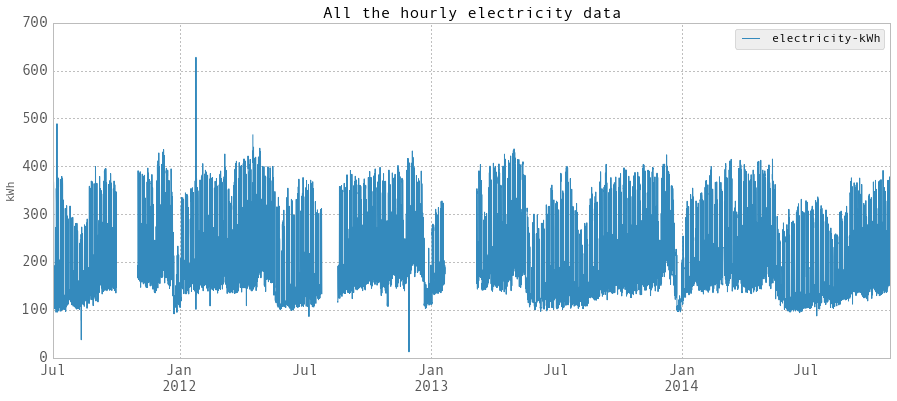

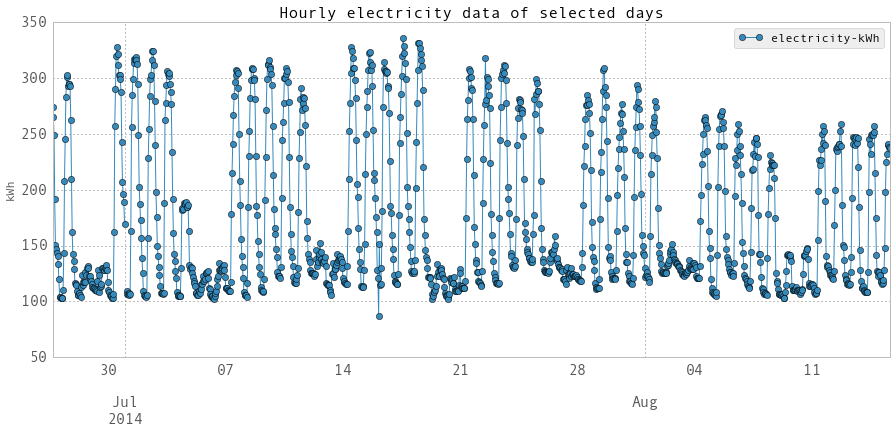

In [12]:
plt.figure()
fig = hourlyElectricity.plot(fontsize = 15, figsize = (15, 6))
plt.tick_params(which=u'major', reset=False, axis = 'y', labelsize = 15)
fig.set_axis_bgcolor('w')
plt.title('All the hourly electricity data', fontsize = 16)
plt.ylabel('kWh')
plt.show()

plt.figure()
fig = hourlyElectricity.iloc[26200:27400,:].plot(marker = 'o',label='hourly electricity', fontsize = 15, figsize = (15, 6))
plt.tick_params(which=u'major', reset=False, axis = 'y', labelsize = 15)
fig.set_axis_bgcolor('w')
plt.title('Hourly electricity data of selected days', fontsize = 16)
plt.ylabel('kWh')
plt.legend()
plt.show()

> Above are the hourly data plots. In the first graph, the blank part is due to missing data when the meters were malfunctioning. In the second graph, you can see difference between day and night, weekday and weekends.

### Derive daily consumption

We manage to get the daily electricity consumption through "reindex".


In [13]:
dailyTimestamp = pd.date_range(start = '2011/7/1', end = '2014/10/31', freq = 'D')
electricityReindexed = electricity.reindex(dailyTimestamp, inplace = False)

# Just in case, in order to use diff method, timestamp has to be in asending order.
electricityReindexed.sort_index(inplace = True)
dailyEnergy = electricityReindexed.diff(periods=1)['energy']

dailyElectricity = pd.DataFrame(data = dailyEnergy.values, index = electricityReindexed.index - np.timedelta64(1,'D'), columns = ['electricity-kWh'])
dailyElectricity['startDay'] = dailyElectricity.index
dailyElectricity['endDay'] = dailyElectricity.index + np.timedelta64(1,'D')

# Filter the data, keep the NaN and generate two excels, with and without Nan

dailyElectricity.loc[abs(dailyElectricity['electricity-kWh']) > 2000000,'electricity-kWh'] = np.nan

time = dailyElectricity.index
index = ((time > np.datetime64('2012-07-26')) & (time < np.datetime64('2012-08-18'))) | ((time > np.datetime64('2013-01-21')) & (time < np.datetime64('2013-03-08')))

dailyElectricity.loc[index,'electricity-kWh'] = np.nan
dailyElectricityWithoutNaN = dailyElectricity.dropna(axis=0, how='any')

dailyElectricity.to_excel('Data/dailyElectricity.xlsx')
dailyElectricityWithoutNaN.to_excel('Data/dailyElectricityWithoutNaN.xlsx')

dailyElectricity.head()

electricity-kWh   startDay     endDay
2011-06-30              NaN 2011-06-30 2011-07-01
2011-07-01              NaN 2011-07-01 2011-07-02
2011-07-02      3630.398480 2011-07-02 2011-07-03
2011-07-03      3750.648885 2011-07-03 2011-07-04
2011-07-04      4568.724044 2011-07-04 2011-07-05

> Above is the daily electricity consumption.

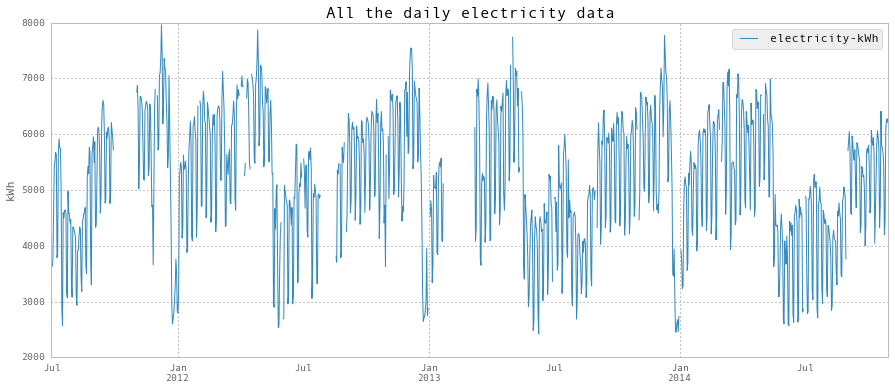

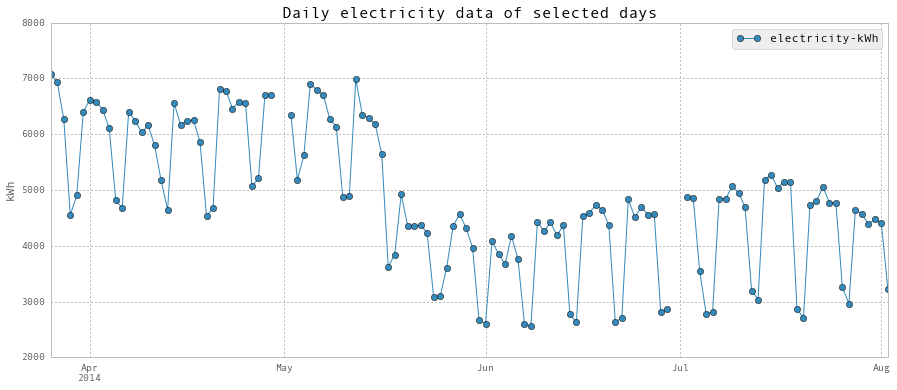

In [14]:
plt.figure()
fig = dailyElectricity.plot(figsize = (15, 6))
fig.set_axis_bgcolor('w')
plt.title('All the daily electricity data', fontsize = 16)
plt.ylabel('kWh')
plt.show()

plt.figure()
fig = dailyElectricity.iloc[1000:1130,:].plot(marker = 'o', figsize = (15, 6))
fig.set_axis_bgcolor('w')
plt.title('Daily electricity data of selected days', fontsize = 16)
plt.ylabel('kWh')
plt.show()

> Above is the daily electricity plot.

The super low electricity consumption happens after semesters end, including Christmas vacations. In addition, as you can see in the second figure, the summer energy consumption is lower when school starts.

## Chilled Water

We clean the chilled water data in the same way as electricity.

In [15]:
chilledWater = df[['Gund Main Energy - Ton-Days']]
chilledWater.head()

Gund Main Energy - Ton-Days
2011-07-01 01:00:00                 17912.537804
2011-07-01 02:00:00                 17912.853518
2011-07-01 03:00:00                 17913.169232
2011-07-01 04:00:00                 17913.484946
2011-07-01 05:00:00                 17913.800660

In [16]:
file = 'Data/monthly chilled water.csv' 
monthlyChilledWaterFromFacility = pd.read_csv(file, header=0)
monthlyChilledWaterFromFacility.set_index(['month'], inplace = True)
monthlyChilledWaterFromFacility.head()

startDate   endDate  chilledWater
month                                   
11-Jul   6/12/11   7/12/11          2258
11-Aug   7/12/11   8/12/11          2095
11-Sep   8/12/11   9/12/11          2200
11-Oct   9/12/11  10/12/11          1664
11-Nov  10/12/11  11/12/11           447

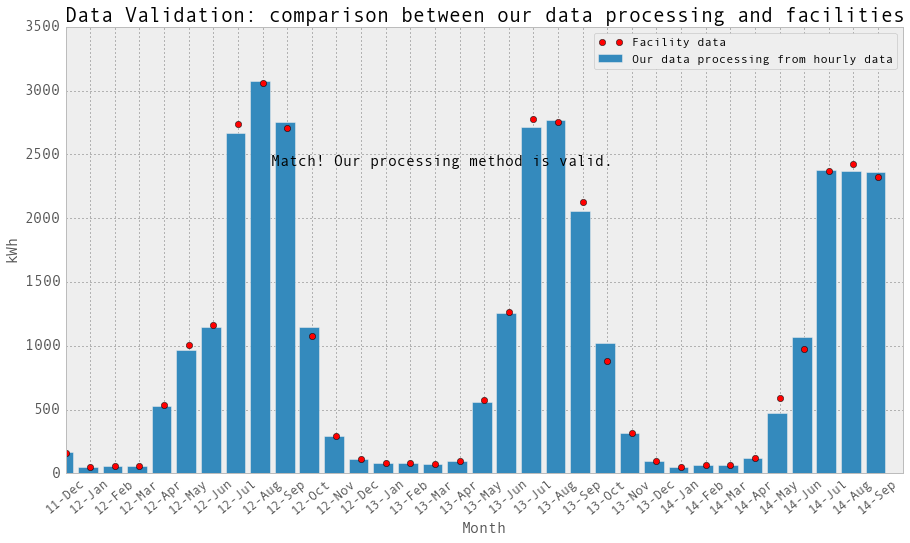

In [17]:
monthlyChilledWaterFromFacility['startDate'] = pd.to_datetime(monthlyChilledWaterFromFacility['startDate'], format="%m/%d/%y")
values = monthlyChilledWaterFromFacility.index.values

keys = np.array(monthlyChilledWaterFromFacility['startDate'])

dates = {}
for key, value in zip(keys, values):
    dates[key] = value

sortedDates =  np.sort(dates.keys())
sortedDates = sortedDates[sortedDates > np.datetime64('2011-11-01')]

months = []
monthlyChilledWaterOrg = np.zeros((len(sortedDates) - 1))
for i in range(len(sortedDates) - 1):
    begin = sortedDates[i]
    end = sortedDates[i+1]
    months.append(dates[sortedDates[i]])
    monthlyChilledWaterOrg[i] = (np.round(chilledWater.loc[end,:] -  chilledWater.loc[begin,:], 1))
    

monthlyChilledWater = pd.DataFrame(data = monthlyChilledWaterOrg, index = months, columns = ['chilledWater-TonDays'])

fig,ax = plt.subplots(1, 1,figsize=(15,8))
#ax.set_axis_bgcolor('w')
#plt.plot(monthlyChilledWater, label='Our data processing from hourly data', marker = 'x', markersize = 15, linestyle = '')
plt.bar(np.arange(len(monthlyChilledWater))-0.5, monthlyChilledWater.values, label='Our data processing from hourly data')
plt.plot(monthlyChilledWaterFromFacility[5:-1]['chilledWater'],'or', label='Facility data')
plt.xticks(np.arange(0,len(months)),months)
plt.xlabel('Month',fontsize=15)
plt.ylabel('kWh',fontsize=15)
plt.xlim([0,len(months)])
plt.legend()
ax.set_xticklabels(months, rotation=40, fontsize=13)
plt.tick_params(which=u'major', reset=False, axis = 'y', labelsize = 15)
plt.title('Data Validation: comparison between our data processing and facilities',fontsize=20)

text = 'Match! Our processing method is valid.'
ax.annotate(text, xy = (15, 2000), 
            xytext = (5, 50), fontsize = 15, 
            textcoords = 'offset points', ha = 'center', va = 'bottom')

plt.show()

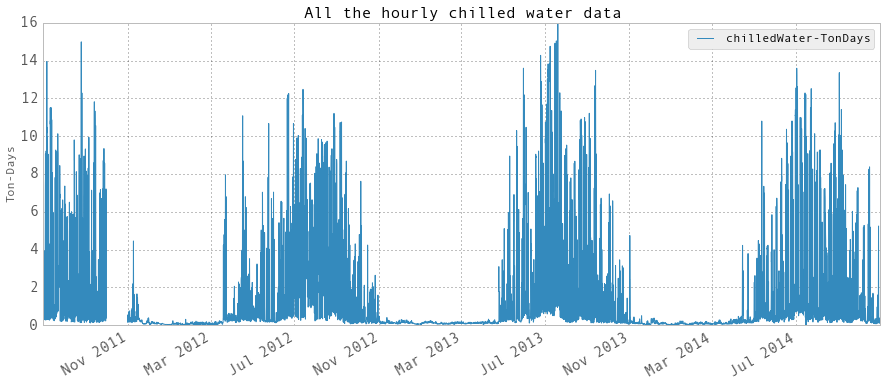

chilledWater-TonDays           startTime  \
2011-07-01 01:00:00                   NaN 2011-07-01 01:00:00   
2011-07-01 02:00:00              0.315714 2011-07-01 02:00:00   
2011-07-01 03:00:00              0.315714 2011-07-01 03:00:00   
2011-07-01 04:00:00              0.315714 2011-07-01 04:00:00   
2011-07-01 05:00:00              0.315714 2011-07-01 05:00:00   

                                endTime  
2011-07-01 01:00:00 2011-07-01 02:00:00  
2011-07-01 02:00:00 2011-07-01 03:00:00  
2011-07-01 03:00:00 2011-07-01 04:00:00  
2011-07-01 04:00:00 2011-07-01 05:00:00  
2011-07-01 05:00:00 2011-07-01 06:00:00

In [55]:
hourlyTimestamp = pd.date_range(start = '2011/7/1', end = '2014/10/31', freq = 'H')
chilledWater.reindex(hourlyTimestamp, inplace = True)

# Just in case, in order to use diff method, timestamp has to be in asending order.
chilledWater.sort_index(inplace = True)
hourlyEnergy = chilledWater.diff(periods=1)

hourlyChilledWater = pd.DataFrame(data = hourlyEnergy.values, index = hourlyEnergy.index, columns = ['chilledWater-TonDays'])
hourlyChilledWater['startTime'] = hourlyChilledWater.index
hourlyChilledWater['endTime'] = hourlyChilledWater.index + np.timedelta64(1,'h')

hourlyChilledWater.loc[abs(hourlyChilledWater['chilledWater-TonDays']) > 50,'chilledWater-TonDays'] = np.nan

hourlyChilledWaterWithoutNaN = hourlyChilledWater.dropna(axis=0, how='any')

hourlyChilledWater.to_excel('Data/hourlyChilledWater.xlsx')
hourlyChilledWaterWithoutNaN.to_excel('Data/hourlyChilledWaterWithoutNaN.xlsx')

plt.figure()
fig = hourlyChilledWater.plot(fontsize = 15, figsize = (15, 6))
plt.tick_params(which=u'major', reset=False, axis = 'y', labelsize = 15)
fig.set_axis_bgcolor('w')
plt.title('All the hourly chilled water data', fontsize = 16)
plt.ylabel('Ton-Days')
plt.show()

hourlyChilledWater.head()

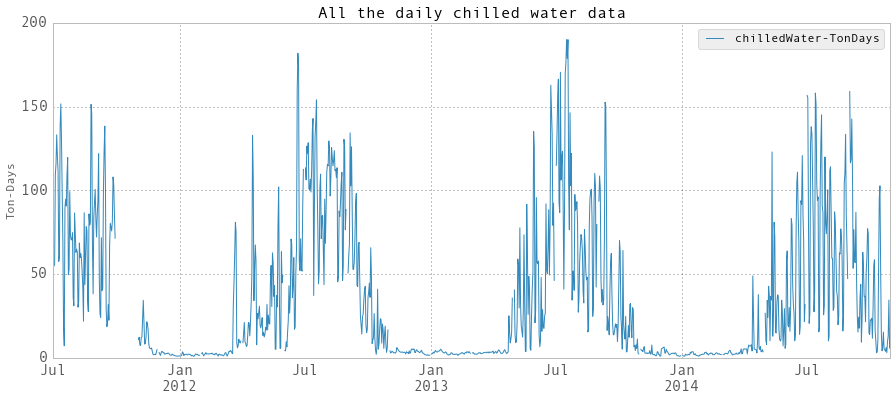

chilledWater-TonDays   startDay     endDay
2011-06-30                   NaN 2011-06-30 2011-07-01
2011-07-01                   NaN 2011-07-01 2011-07-02
2011-07-02             54.741028 2011-07-02 2011-07-03
2011-07-03             55.649728 2011-07-03 2011-07-04
2011-07-04            109.049077 2011-07-04 2011-07-05

In [19]:
dailyTimestamp = pd.date_range(start = '2011/7/1', end = '2014/10/31', freq = 'D')
chilledWaterReindexed = chilledWater.reindex(dailyTimestamp, inplace = False)

chilledWaterReindexed.sort_index(inplace = True)
dailyEnergy = chilledWaterReindexed.diff(periods=1)['Gund Main Energy - Ton-Days']

dailyChilledWater = pd.DataFrame(data = dailyEnergy.values, index = chilledWaterReindexed.index - np.timedelta64(1,'D'), columns = ['chilledWater-TonDays'])
dailyChilledWater['startDay'] = dailyChilledWater.index
dailyChilledWater['endDay'] = dailyChilledWater.index + np.timedelta64(1,'D')

dailyChilledWaterWithoutNaN = dailyChilledWater.dropna(axis=0, how='any')

dailyChilledWater.to_excel('Data/dailyChilledWater.xlsx')
dailyChilledWaterWithoutNaN.to_excel('Data/dailyChilledWaterWithoutNaN.xlsx')

plt.figure()
fig = dailyChilledWater.plot(fontsize = 15, figsize = (15, 6))
plt.tick_params(which=u'major', reset=False, axis = 'y', labelsize = 15)
fig.set_axis_bgcolor('w')
plt.title('All the daily chilled water data', fontsize = 16)
plt.ylabel('Ton-Days')
plt.show()


dailyChilledWater.head()

## Steam

In [20]:
steam = df[['Gund Condensate FlowTotal - LBS']]
steam.head()

Gund Condensate FlowTotal - LBS
2011-07-01 01:00:00                  15443350.388455
2011-07-01 02:00:00                  15443459.322917
2011-07-01 03:00:00                  15443574.687500
2011-07-01 04:00:00                  15443701.953125
2011-07-01 05:00:00                  15443818.359375

In [21]:
file = 'Data/monthly steam.csv' 
monthlySteamFromFacility = pd.read_csv(file, header=0)
monthlySteamFromFacility.set_index(['month'], inplace = True)
monthlySteamFromFacility.head()

startDate     endDate  steam
month                                
Jul 11   6/17/2011   7/21/2011    0.0
Aug 11   7/21/2011   8/20/2011    0.0
Sep 11   8/20/2011   9/17/2011    0.0
Oct 11   9/17/2011  10/20/2011  246.5
Nov 11  10/20/2011  11/20/2011  786.1

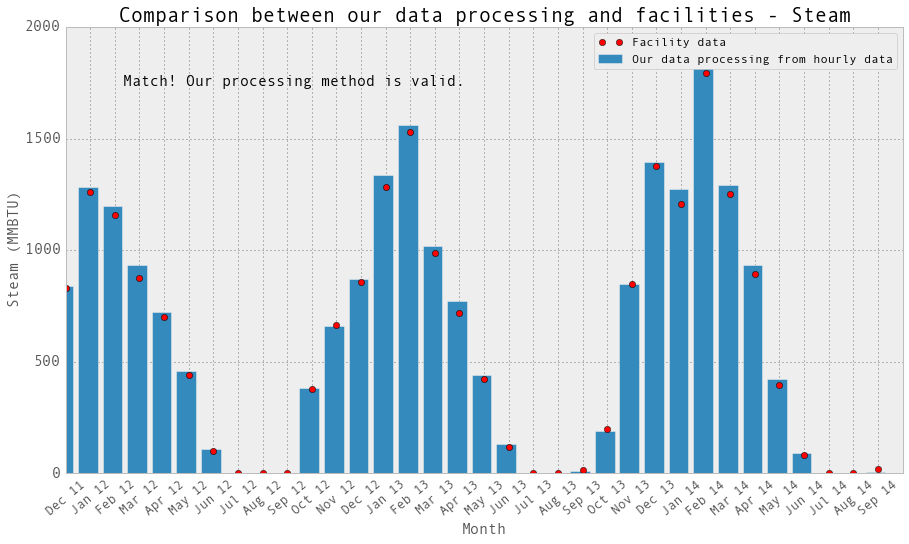

In [22]:
monthlySteamFromFacility['startDate'] = pd.to_datetime(monthlySteamFromFacility['startDate'], format="%m/%d/%Y")
values = monthlySteamFromFacility.index.values

keys = np.array(monthlySteamFromFacility['startDate'])

dates = {}
for key, value in zip(keys, values):
    dates[key] = value

sortedDates =  np.sort(dates.keys())
sortedDates = sortedDates[sortedDates > np.datetime64('2011-11-01')]

months = []
monthlySteamOrg = np.zeros((len(sortedDates) - 1))
for i in range(len(sortedDates) - 1):
    begin = sortedDates[i]
    end = sortedDates[i+1]
    months.append(dates[sortedDates[i]])
    monthlySteamOrg[i] = (np.round(steam.loc[end,:] -  steam.loc[begin,:], 1))
    

monthlySteam = pd.DataFrame(data = monthlySteamOrg, index = months, columns = ['steam-LBS'])

# 867 LBS ~= 1MMBTU steam

fig,ax = plt.subplots(1, 1,figsize=(15,8))
#ax.set_axis_bgcolor('w')
#plt.plot(monthlySteam/867, label='Our data processing from hourly data')
plt.bar(np.arange(len(monthlySteam))-0.5, monthlySteam.values/867, label='Our data processing from hourly data')
plt.plot(monthlySteamFromFacility.loc[months,'steam'],'or', label='Facility data')
plt.xticks(np.arange(0,len(months)),months)
plt.xlabel('Month',fontsize=15)
plt.ylabel('Steam (MMBTU)',fontsize=15)
plt.xlim([0,len(months)])
plt.legend()
ax.set_xticklabels(months, rotation=40, fontsize=13)
plt.tick_params(which=u'major', reset=False, axis = 'y', labelsize = 15)
plt.title('Comparison between our data processing and facilities - Steam',fontsize=20)

text = 'Match! Our processing method is valid.'
ax.annotate(text, xy = (9, 1500), 
            xytext = (5, 50), fontsize = 15, 
            textcoords = 'offset points', ha = 'center', va = 'bottom')

plt.show()

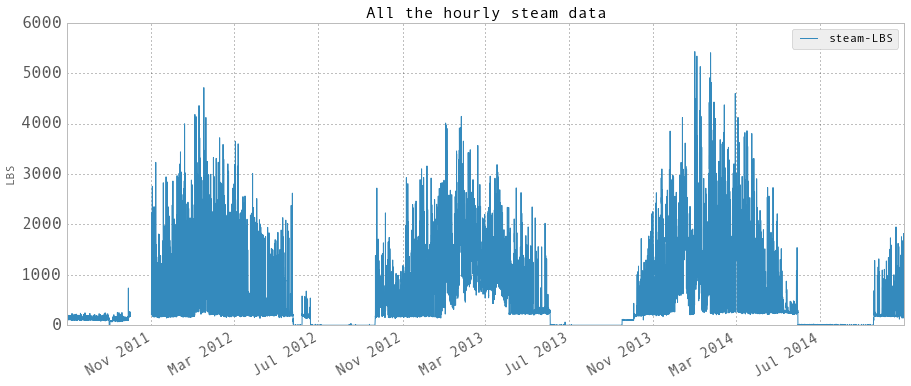

steam-LBS           startTime             endTime
2011-07-01 01:00:00         NaN 2011-07-01 01:00:00 2011-07-01 02:00:00
2011-07-01 02:00:00  108.934462 2011-07-01 02:00:00 2011-07-01 03:00:00
2011-07-01 03:00:00  115.364583 2011-07-01 03:00:00 2011-07-01 04:00:00
2011-07-01 04:00:00  127.265625 2011-07-01 04:00:00 2011-07-01 05:00:00
2011-07-01 05:00:00  116.406250 2011-07-01 05:00:00 2011-07-01 06:00:00

In [23]:
hourlyTimestamp = pd.date_range(start = '2011/7/1', end = '2014/10/31', freq = 'H')
steam.reindex(hourlyTimestamp, inplace = True)

# Just in case, in order to use diff method, timestamp has to be in asending order.
steam.sort_index(inplace = True)
hourlyEnergy = steam.diff(periods=1)

hourlySteam = pd.DataFrame(data = hourlyEnergy.values, index = hourlyEnergy.index, columns = ['steam-LBS'])
hourlySteam['startTime'] = hourlySteam.index
hourlySteam['endTime'] = hourlySteam.index + np.timedelta64(1,'h')

hourlySteam.loc[abs(hourlySteam['steam-LBS']) > 100000,'steam-LBS'] = np.nan

plt.figure()
fig = hourlySteam.plot(fontsize = 15, figsize = (15, 6))
plt.tick_params(which=u'major', reset=False, axis = 'y', labelsize = 17)
fig.set_axis_bgcolor('w')
plt.title('All the hourly steam data', fontsize = 16)
plt.ylabel('LBS')
plt.show()

hourlySteamWithoutNaN = hourlySteam.dropna(axis=0, how='any')

hourlySteam.to_excel('Data/hourlySteam.xlsx')
hourlySteamWithoutNaN.to_excel('Data/hourlySteamWithoutNaN.xlsx')

hourlySteam.head()

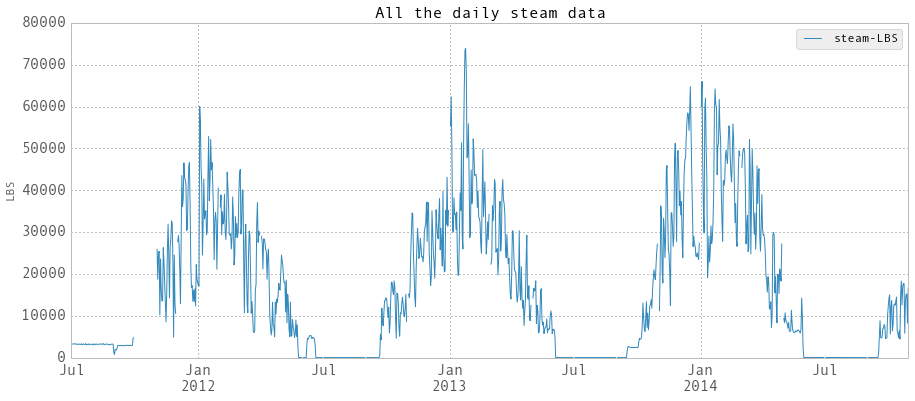

steam-LBS   startDay     endDay
2011-06-30          NaN 2011-06-30 2011-07-01
2011-07-01          NaN 2011-07-01 2011-07-02
2011-07-02  3250.651042 2011-07-02 2011-07-03
2011-07-03  3271.276042 2011-07-03 2011-07-04
2011-07-04  3236.718750 2011-07-04 2011-07-05

In [24]:
dailyTimestamp = pd.date_range(start = '2011/7/1', end = '2014/10/31', freq = 'D')
steamReindexed = steam.reindex(dailyTimestamp, inplace = False)

steamReindexed.sort_index(inplace = True)
dailyEnergy = steamReindexed.diff(periods=1)['Gund Condensate FlowTotal - LBS']

dailySteam = pd.DataFrame(data = dailyEnergy.values, index = steamReindexed.index - np.timedelta64(1,'D'), columns = ['steam-LBS'])
dailySteam['startDay'] = dailySteam.index
dailySteam['endDay'] = dailySteam.index + np.timedelta64(1,'D')

plt.figure()
fig = dailySteam.plot(fontsize = 15, figsize = (15, 6))
plt.tick_params(which=u'major', reset=False, axis = 'y', labelsize = 15)
fig.set_axis_bgcolor('w')
plt.title('All the daily steam data', fontsize = 16)
plt.ylabel('LBS')
plt.show()

dailySteamWithoutNaN = dailyChilledWater.dropna(axis=0, how='any')

dailySteam.to_excel('Data/dailySteam.xlsx')
dailySteamWithoutNaN.to_excel('Data/dailySteamWithoutNaN.xlsx')

dailySteam.head()

## Weather data

### Original data

There are <b>two</b> sources for weather data.
* Year 2014: From local weather on the roof of GSD (Graduate School of Design) building Gund.
* Year 2012 & 2013: purchased weather data from weather stations located in Cambridge, MA. Please note that year 2012 and 2013 data were from different weather stations.

> Here is the orginal weather data after a little cleaning including unit conversion. AS you can see, the interval is 5-minute.

In [25]:
weather2014 = pd.read_excel('Data/weather-2014.xlsx')
weather2014.head()

Datetime   T-C  RH-%  Tdew-C  windDirection  windSpeed-m/s  \
0 2014-01-01 00:00:00 -5.02  53.2  -13.07            256            4.5   
1 2014-01-01 00:05:00 -5.14  54.3  -12.93            257            4.0   
2 2014-01-01 00:10:00 -5.08  53.4  -13.08            258            3.5   
3 2014-01-01 00:15:00 -5.17  52.6  -13.35            257            2.8   
4 2014-01-01 00:20:00 -5.23  52.9  -13.33            248            2.5   

   pressure-mbar  solarRadiation-W/m2  
0         1020.8                    1  
1         1020.7                    1  
2         1021.1                    1  
3         1021.0                    1  
4         1021.2                    1

Convert to hourly by resampling method.

> Here is the clean hourly weather data of year 2014.

In [26]:
weather2014 = weather2014.set_index('Datetime')
weather2014 = weather2014.resample('H')
weather2014.head()

T-C       RH-%     Tdew-C  windDirection  \
Datetime                                                             
2014-01-01 00:00:00 -5.281667  52.858333 -13.393333     253.500000   
2014-01-01 01:00:00 -5.725000  51.650000 -14.090833     253.000000   
2014-01-01 02:00:00 -6.002500  50.766667 -14.555833     239.250000   
2014-01-01 03:00:00 -6.320833  49.675000 -15.114167     234.333333   
2014-01-01 04:00:00 -6.535833  49.708333 -15.305833     227.333333   

                     windSpeed-m/s  pressure-mbar  solarRadiation-W/m2  
Datetime                                                                
2014-01-01 00:00:00       2.775000    1021.158333                    1  
2014-01-01 01:00:00       2.350000    1021.700000                    1  
2014-01-01 02:00:00       1.133333    1022.708333                    1  
2014-01-01 03:00:00       1.191667    1023.233333                    1  
2014-01-01 04:00:00       1.633333    1023.925000                    1

> Here is the orginal weather data of the year 2013 and 2014 after a little cleaning including unit conversion. As you can see, the Datetime format is not correct.

In [27]:
weather2012and2013 = pd.read_excel('Data/weather-2012-2013.xlsx')
weather2012and2013.head()

Datetime  RH-%  windDirection  solarRadiation-W/m2  T-C  Tdew-C  \
0  2012-01-01-01    87            310                    0    4     1.9   
1  2012-01-01-02    87            280                    0    4     1.9   
2  2012-01-01-03    81            270                    0    5     1.9   
3  2012-01-01-04    76            290                    0    6     1.9   
4  2012-01-01-05    87            280                    0    4     1.9   

   pressure-mbar  windSpeed-m/s  
0           1004       4.166670  
1           1005       4.166670  
2           1006       4.166670  
3           1007       4.722226  
4           1007       3.055558

Correct the timestep.

> Here is the hourly data after cleaning.

In [28]:
weather2012and2013['Datetime'] = pd.to_datetime(weather2012and2013['Datetime'], format='%Y-%m-%d-%H')
weather2012and2013 = weather2012and2013.set_index('Datetime')
weather2012and2013.head()

RH-%  windDirection  solarRadiation-W/m2  T-C  Tdew-C  \
Datetime                                                                     
2012-01-01 01:00:00    87            310                    0    4     1.9   
2012-01-01 02:00:00    87            280                    0    4     1.9   
2012-01-01 03:00:00    81            270                    0    5     1.9   
2012-01-01 04:00:00    76            290                    0    6     1.9   
2012-01-01 05:00:00    87            280                    0    4     1.9   

                     pressure-mbar  windSpeed-m/s  
Datetime                                           
2012-01-01 01:00:00           1004       4.166670  
2012-01-01 02:00:00           1005       4.166670  
2012-01-01 03:00:00           1006       4.166670  
2012-01-01 04:00:00           1007       4.722226  
2012-01-01 05:00:00           1007       3.055558

### Hourly weather data

Combine two files and add more features including cooling degrees, heating degrees, humidity ratio and dehumidification.

> Here is <b>all</b> the hourly weather data.

In [29]:
# Combine two weather files
hourlyWeather = weather2014.append(weather2012and2013)
hourlyWeather.index.name = None
hourlyWeather.sort_index(inplace = True)

# Add more features

# Convert relative humidity to specific humidity

Mw=18.0160 # molecular weight of water
Md=28.9660 # molecular weight of dry air
R =  8.31432E3 # gas constant
Rd = R/Md # specific gas constant for dry air
Rv = R/Mw # specific gas constant for vapour
Lv = 2.5e6 # heat release for condensation of water vapour [J kg-1]
eps = Mw/Md

#saturation pressure
def esat(T):
    ''' get sateration pressure (units [Pa]) for a given air temperature (units [K])'''
    from numpy import log10
    TK = 273.15
    e1 = 101325.0
    logTTK = log10(T/TK)
    esat =  e1*10**(10.79586*(1-TK/T)-5.02808*logTTK+ 1.50474*1e-4*(1.-10**(-8.29692*(T/TK-1)))+ 0.42873*1e-3*(10**(4.76955*(1-TK/T))-1)-2.2195983) 
    return esat

def rh2sh(RH,p,T):
    '''purpose: conversion relative humidity (unitless) to specific humidity (humidity ratio) [kg/kg]'''
    es = esat(T)
    W = Mw/Md*RH*es/(p-RH*es)

    return W/(1.+W)


p = hourlyWeather['pressure-mbar'] * 100
RH = hourlyWeather['RH-%'] / 100
T = hourlyWeather['T-C'] + 273.15
w = rh2sh(RH,p,T)

hourlyWeather['humidityRatio-kg/kg'] = w
hourlyWeather['coolingDegrees'] = hourlyWeather['T-C'] - 12
hourlyWeather.loc[hourlyWeather['coolingDegrees'] < 0, 'coolingDegrees'] = 0

hourlyWeather['heatingDegrees'] = 15 - hourlyWeather['T-C']
hourlyWeather.loc[hourlyWeather['heatingDegrees'] < 0, 'heatingDegrees'] = 0

hourlyWeather['dehumidification'] = hourlyWeather['humidityRatio-kg/kg'] - 0.00886
hourlyWeather.loc[hourlyWeather['dehumidification'] < 0, 'dehumidification'] = 0

#hourlyWeather.to_excel('Data/hourlyWeather.xlsx')
hourlyWeather.head()

RH-%  T-C  Tdew-C  pressure-mbar  solarRadiation-W/m2  \
2012-01-01 01:00:00    87    4     1.9           1004                    0   
2012-01-01 02:00:00    87    4     1.9           1005                    0   
2012-01-01 03:00:00    81    5     1.9           1006                    0   
2012-01-01 04:00:00    76    6     1.9           1007                    0   
2012-01-01 05:00:00    87    4     1.9           1007                    0   

                     windDirection  windSpeed-m/s  humidityRatio-kg/kg  \
2012-01-01 01:00:00            310       4.166670             0.004396   
2012-01-01 02:00:00            280       4.166670             0.004391   
2012-01-01 03:00:00            270       4.166670             0.004380   
2012-01-01 04:00:00            290       4.722226             0.004401   
2012-01-01 05:00:00            280       3.055558             0.004382   

                     coolingDegrees  heatingDegrees  dehumidification  
2012-01-01 01:00:00               0              11                 0  
2012-01-01 02:00:00               0              11                 0  
2012-01-01 03:00:00               0              10                 0  
2012-01-01 04:00:00               0               9                 0  
2012-01-01 05:00:00               0              11                 0

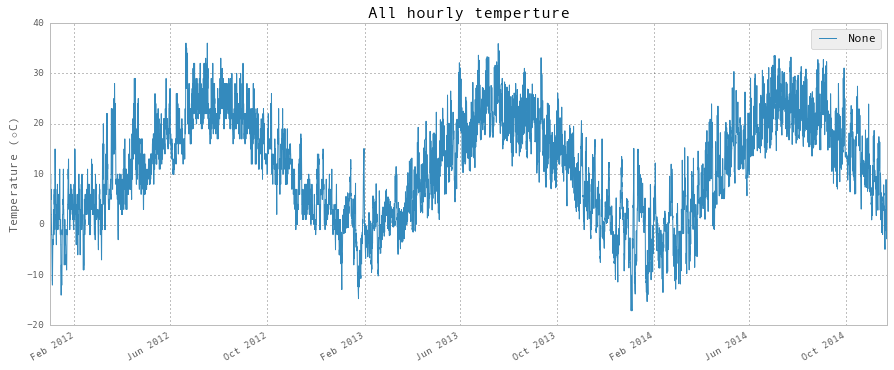

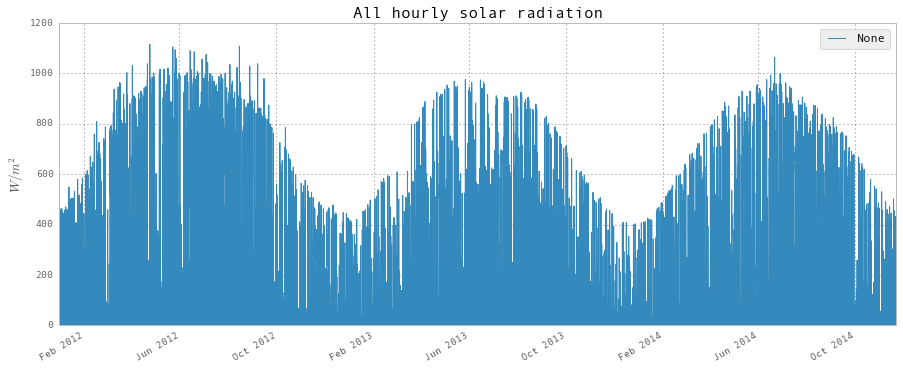

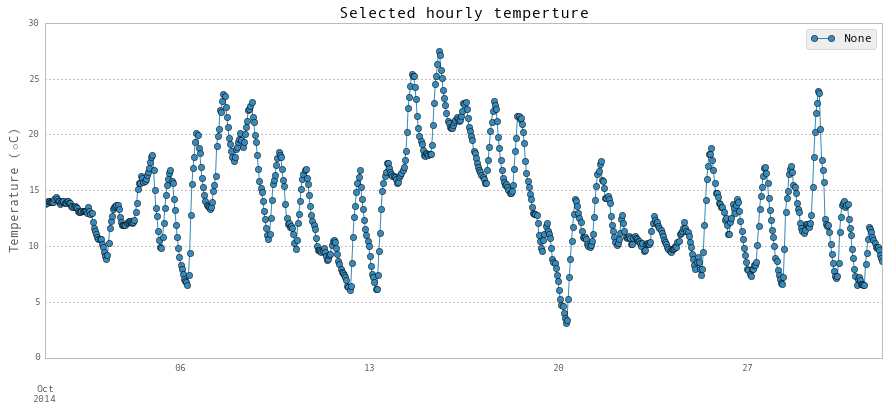

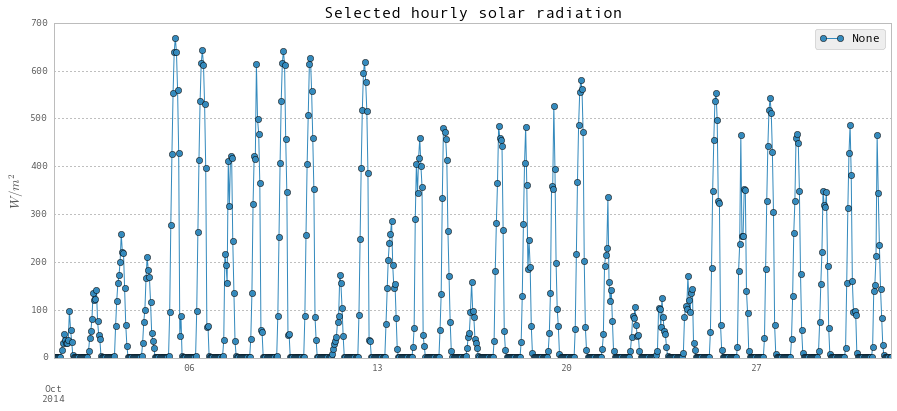

In [30]:
plt.figure()
fig = hourlyWeather.plot(y = 'T-C', figsize = (15, 6))
fig.set_axis_bgcolor('w')
plt.title('All hourly temperture', fontsize = 16)
plt.ylabel(r'Temperature ($\circ$C)')
plt.show()

plt.figure()
fig = hourlyWeather.plot(y = 'solarRadiation-W/m2', figsize = (15, 6))
fig.set_axis_bgcolor('w')
plt.title('All hourly solar radiation', fontsize = 16)
plt.ylabel(r'$W/m^2$', fontsize = 13)
plt.show()

plt.figure()
fig = hourlyWeather['2014-10'].plot(y = 'T-C', figsize = (15, 6), marker = 'o')
fig.set_axis_bgcolor('w')
plt.title('Selected hourly temperture',fontsize = 16)
plt.ylabel(r'Temperature ($\circ$C)',fontsize = 13)
plt.show()

plt.figure()
fig = hourlyWeather['2014-10'].plot(y = 'solarRadiation-W/m2', figsize = (15, 6), marker ='o')
fig.set_axis_bgcolor('w')
plt.title('Selected hourly solar radiation', fontsize = 16)
plt.ylabel(r'$W/m^2$', fontsize = 13)
plt.show()

### Daily weather data

In [31]:
dailyWeather = hourlyWeather.resample('D')
#dailyWeather.to_excel('Data/dailyWeather.xlsx')
dailyWeather.head()

RH-%       T-C     Tdew-C  pressure-mbar  \
2012-01-01  76.652174  7.173913   3.073913    1004.956522   
2012-01-02  55.958333  5.833333  -2.937500     994.625000   
2012-01-03  42.500000 -3.208333 -12.975000    1002.125000   
2012-01-04  41.541667 -7.083333 -16.958333    1008.250000   
2012-01-05  46.916667 -0.583333  -9.866667    1002.041667   

            solarRadiation-W/m2  windDirection  windSpeed-m/s  \
2012-01-01            95.260870     236.086957       4.118361   
2012-01-02            87.333333     253.750000       5.914357   
2012-01-03            95.708333     302.916667       6.250005   
2012-01-04            98.750000     286.666667       5.127319   
2012-01-05            90.750000     258.333333       5.162041   

            humidityRatio-kg/kg  coolingDegrees  heatingDegrees  \
2012-01-01             0.004796               0        7.826087   
2012-01-02             0.003415               0        9.166667   
2012-01-03             0.001327               0       18.208333   
2012-01-04             0.000890               0       22.083333   
2012-01-05             0.001746               0       15.583333   

            dehumidification  
2012-01-01                 0  
2012-01-02                 0  
2012-01-03                 0  
2012-01-04                 0  
2012-01-05                 0

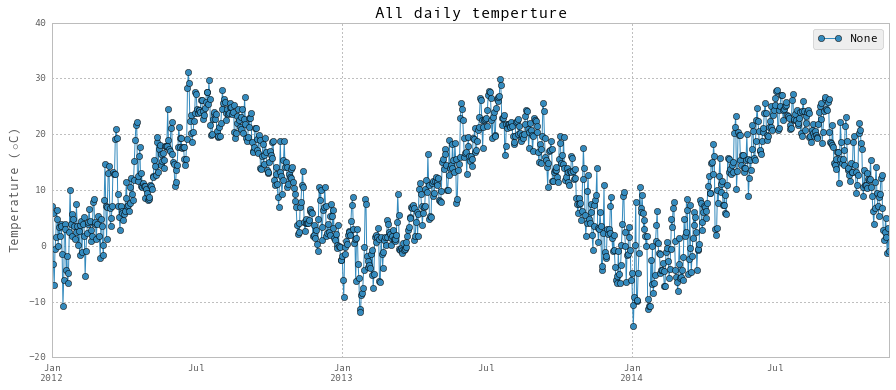

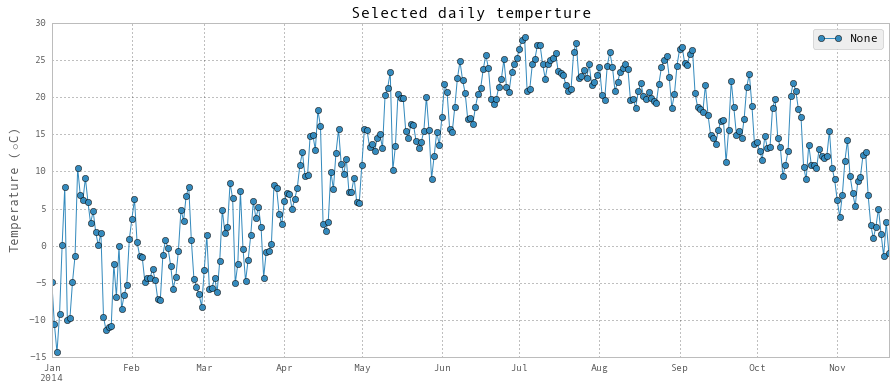

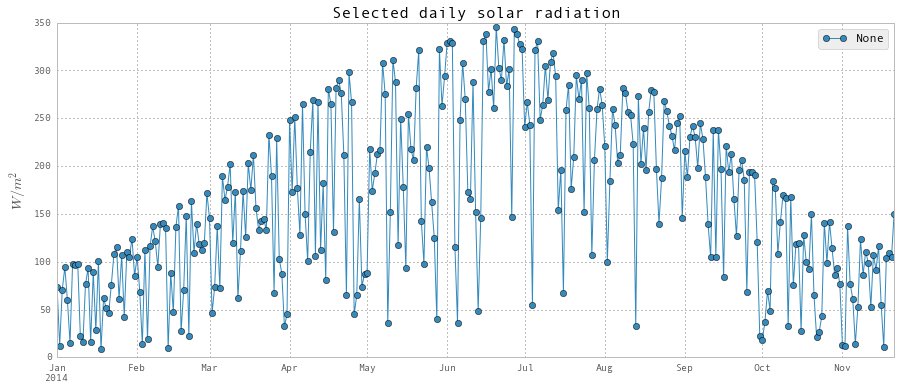

In [32]:
plt.figure()
fig = dailyWeather.plot(y = 'T-C', figsize = (15, 6), marker ='o')
fig.set_axis_bgcolor('w')
plt.title('All daily temperture', fontsize = 16)
plt.ylabel(r'Temperature ($\circ$C)', fontsize = 13)
plt.show()

plt.figure()
fig = dailyWeather['2014'].plot(y = 'T-C', figsize = (15, 6), marker ='o')
fig.set_axis_bgcolor('w')
plt.title('Selected daily temperture', fontsize = 16)
plt.ylabel(r'Temperature ($\circ$C)', fontsize = 13)
plt.show()

plt.figure()
fig = dailyWeather['2014'].plot(y = 'solarRadiation-W/m2', figsize = (15, 6), marker ='o')
fig.set_axis_bgcolor('w')
plt.title('Selected daily solar radiation', fontsize = 16)
plt.ylabel(r'$W/m^2$', fontsize = 14)
plt.show()

## Features related to occupancy

This is a number between 0 and 1. 0 indicated no occupants, 1 indicates normal occupancy. This is an estimate based on holidays, weekends and school academic calendar.

In [33]:
holidays = pd.read_excel('Data/holidays.xlsx')
holidays.head()

startDate    endDate  value
0 2011-07-01 2011-09-06    0.5
1 2011-10-10 2011-10-11    0.6
2 2011-11-24 2011-11-28    0.2
3 2011-12-22 2011-12-24    0.1
4 2011-12-24 2012-01-02    0.0

In [34]:
hourlyTimestamp = pd.date_range(start = '2011/7/1', end = '2014/10/31', freq = 'H')
occupancy = np.ones(len(hourlyTimestamp)) 

hourlyOccupancy = pd.DataFrame(data = occupancy, index = hourlyTimestamp, columns = ['occupancy'])


Saturdays = hourlyOccupancy.index.weekday == 5
Sundays = hourlyOccupancy.index.weekday == 6
hourlyOccupancy.loc[Saturdays, 'occupancy'] = 0.5 
hourlyOccupancy.loc[Sundays, 'occupancy'] = 0.5 


for i in range(len(holidays)):
    timestamp = pd.date_range(start = holidays.loc[i, 'startDate'], end = holidays.loc[i, 'endDate'], freq = 'H')
    hourlyOccupancy.loc[timestamp, 'occupancy'] = holidays.loc[i, 'value']

#hourlyHolidays['Datetime'] = pd.to_datetime(hourlyHolidays['Datetime'], format="%Y-%m-%d %H:%M:%S")
hourlyOccupancy['cosHour'] = np.cos((hourlyOccupancy.index.hour - 3) * 2 * np.pi / 24)

dailyOccupancy = hourlyOccupancy.resample('D')
dailyOccupancy.drop('cosHour', axis = 1, inplace = True)

## Merge energy consumption data with weather and occupancy features

In [35]:
hourlyElectricityWithFeatures = hourlyElectricity.join(hourlyWeather, how = 'inner')
hourlyElectricityWithFeatures = hourlyElectricityWithFeatures.join(hourlyOccupancy, how = 'inner')
hourlyElectricityWithFeatures.dropna(axis=0, how='any', inplace = True)
hourlyElectricityWithFeatures.to_excel('Data/hourlyElectricityWithFeatures.xlsx')
hourlyElectricityWithFeatures.head()

electricity-kWh           startTime             endTime  \
2012-01-01 01:00:00       111.479277 2012-01-01 01:00:00 2012-01-01 02:00:00   
2012-01-01 02:00:00       117.989395 2012-01-01 02:00:00 2012-01-01 03:00:00   
2012-01-01 03:00:00       119.010131 2012-01-01 03:00:00 2012-01-01 04:00:00   
2012-01-01 04:00:00       116.005587 2012-01-01 04:00:00 2012-01-01 05:00:00   
2012-01-01 05:00:00       111.132977 2012-01-01 05:00:00 2012-01-01 06:00:00   

                     RH-%  T-C  Tdew-C  pressure-mbar  solarRadiation-W/m2  \
2012-01-01 01:00:00    87    4     1.9           1004                    0   
2012-01-01 02:00:00    87    4     1.9           1005                    0   
2012-01-01 03:00:00    81    5     1.9           1006                    0   
2012-01-01 04:00:00    76    6     1.9           1007                    0   
2012-01-01 05:00:00    87    4     1.9           1007                    0   

                     windDirection  windSpeed-m/s  humidityRatio-kg/kg  \
2012-01-01 01:00:00            310       4.166670             0.004396   
2012-01-01 02:00:00            280       4.166670             0.004391   
2012-01-01 03:00:00            270       4.166670             0.004380   
2012-01-01 04:00:00            290       4.722226             0.004401   
2012-01-01 05:00:00            280       3.055558             0.004382   

                     coolingDegrees  heatingDegrees  dehumidification  \
2012-01-01 01:00:00               0              11                 0   
2012-01-01 02:00:00               0              11                 0   
2012-01-01 03:00:00               0              10                 0   
2012-01-01 04:00:00               0               9                 0   
2012-01-01 05:00:00               0              11                 0   

                     occupancy   cosHour  
2012-01-01 01:00:00          0  0.866025  
2012-01-01 02:00:00          0  0.965926  
2012-01-01 03:00:00          0  1.000000  
2012-01-01 04:00:00          0  0.965926  
2012-01-01 05:00:00          0  0.866025

In [36]:
hourlyChilledWaterWithFeatures = hourlyChilledWater.join(hourlyWeather, how = 'inner')
hourlyChilledWaterWithFeatures = hourlyChilledWaterWithFeatures.join(hourlyOccupancy, how = 'inner')
hourlyChilledWaterWithFeatures.dropna(axis=0, how='any', inplace = True)
hourlyChilledWaterWithFeatures.to_excel('Data/hourlyChilledWaterWithFeatures.xlsx')

hourlySteamWithFeatures = hourlySteam.join(hourlyWeather, how = 'inner')
hourlySteamWithFeatures = hourlySteamWithFeatures.join(hourlyOccupancy, how = 'inner')
hourlySteamWithFeatures.dropna(axis=0, how='any', inplace = True)
hourlySteamWithFeatures.to_excel('Data/hourlySteamWithFeatures.xlsx')

dailyElectricityWithFeatures = dailyElectricity.join(dailyWeather, how = 'inner')
dailyElectricityWithFeatures = dailyElectricityWithFeatures.join(dailyOccupancy, how = 'inner')
dailyElectricityWithFeatures.dropna(axis=0, how='any', inplace = True)
dailyElectricityWithFeatures.to_excel('Data/dailyElectricityWithFeatures.xlsx')

dailyChilledWaterWithFeatures = dailyChilledWater.join(dailyWeather, how = 'inner')
dailyChilledWaterWithFeatures = dailyChilledWaterWithFeatures.join(dailyOccupancy, how = 'inner')
dailyChilledWaterWithFeatures.dropna(axis=0, how='any', inplace = True)
dailyChilledWaterWithFeatures.to_excel('Data/dailyChilledWaterWithFeatures.xlsx')

dailySteamWithFeatures = dailySteam.join(dailyWeather, how = 'inner')
dailySteamWithFeatures = dailySteamWithFeatures.join(dailyOccupancy, how = 'inner')
dailySteamWithFeatures.dropna(axis=0, how='any', inplace = True)
dailySteamWithFeatures.to_excel('Data/dailySteamWithFeatures.xlsx')

## A note for features

### Nomenclature (Alphabetically)
<p><b> coolingDegrees</b>: if T-C - 12 > 0, then = T-C - 12, else = 0. Assume that when outdoor temperature is below 12C, no cooling is needed, which is true for many buildings. This will be useful for daily prediction, because the average of hourly cooling degrees is better than average of hourly temperature.</p>
<p><b> cosHour</b>: $\text{cos}(\text{hourOfDay} \cdot \frac{2\pi}{24})$</p>
<p><b> dehumidification</b>: if humidityRatio - 0.00886 > 0, then = humidityRatio - 0.00886, else = 0. This will be useful for chilled water prediction, especially daily chilled water prediction.</p>
<p><b> heatingDegrees</b>: if 15 - T-C > 0, then = 15 - T-C, else = 0. Assume that when outdoor temperature is above 15C, no heating is needed. This will be useful for daily prediction, because the average of hourly heating degrees is better than average of hourly temperature.</p>
<p><b> occupancy</b>: A number between 0 and 1. 0 indicated no occupants, 1 indicates normal occupancy. This is an estimate based on holidays, weekends and school academic calendar.</p>
<p><b> pressure-mbar</b>: atmospheric pressure</p> 
<p><b> RH-% </b>: Relative humidity</p>
<p><b> T-C </b>: Dry-bulb temperature</p>
<p><b> Tdew-C </b>: Dew-point temperature</p>

### Humidity
Humidity ratio is important for chilled water prediction as chilled water is also used to dry the air discharged to rooms. Using humidity ratio will be more efficient and effective than using RH and dew point temperature.


#3. Exploratory Analysis

In [37]:
%matplotlib inline 

import requests 
from StringIO import StringIO
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting 
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations
from __future__ import division
import matplotlib

pd.options.display.mpl_style = 'default'

## Monthly energy consumption

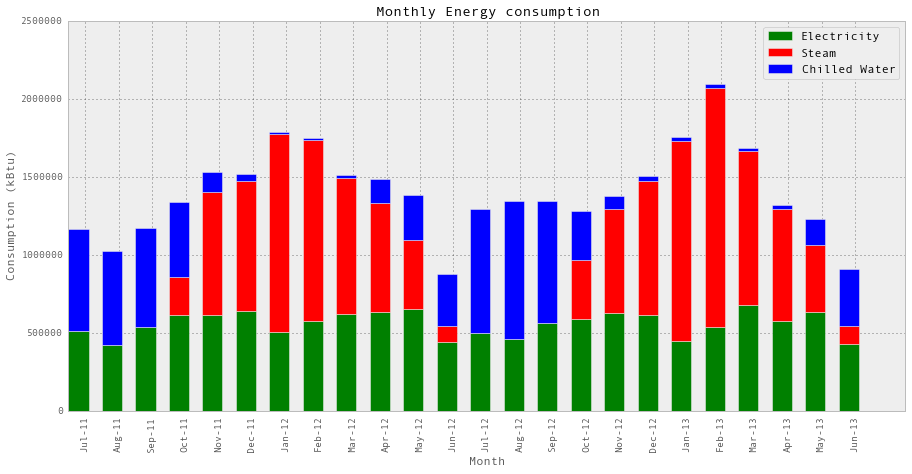

In [56]:
pd.options.display.mpl_style = 'default'
consumption = pd.read_csv('Data/Monthly_Energy_Gund.csv')
for i in range(len(consumption)):
    consumption['CW-kBtu'][i] = float(consumption['CW-kBtu'].values[i].replace(',', ''))
    consumption['EL-kBtu'][i] = float(consumption['EL-kBtu'].values[i].replace(',', ''))
    consumption['ST-kBtu'][i] = float(consumption['ST-kBtu'].values[i].replace(',', ''))

time_index = np.arange(len(consumption)) 
plt.figure(figsize=(15,7))
b1 = plt.bar(time_index, consumption['EL-kBtu'], width = 0.6, color='g')
b2 = plt.bar(time_index, consumption['ST-kBtu'], bottom=consumption['EL-kBtu'], width = 0.6, color='r')
b3 = plt.bar(time_index, consumption['CW-kBtu'], bottom=consumption['EL-kBtu']+consumption['ST-kBtu'], width = 0.6, color='b')

plt.xticks(time_index+0.5, consumption['Time'], rotation=90)
plt.title('Monthly Energy consumption')
plt.xlabel('Month')
plt.ylabel('Consumption (kBtu)')
plt.legend( (b1, b2, b3), ('Electricity', 'Steam', 'Chilled Water') )

## Electricity energy consumption pattern

First, let's see what we can find in hourly and daily electricity energy consumption.

In [39]:
hourlyElectricity = pd.read_excel('Data/hourlyElectricity.xlsx')

index = (hourlyElectricity['startTime'] >= np.datetime64('2011-07-03')) & (hourlyElectricity['startTime'] < np.datetime64('2014-10-26'))
hourlyElectricityForVisualization = hourlyElectricity.loc[index,'electricity-kWh']

print "Data length: ", len(hourlyElectricityForVisualization)/24/7, " weeks"

Data length:  173.0  weeks


<matplotlib.colorbar.Colorbar instance at 0x10a90db00>

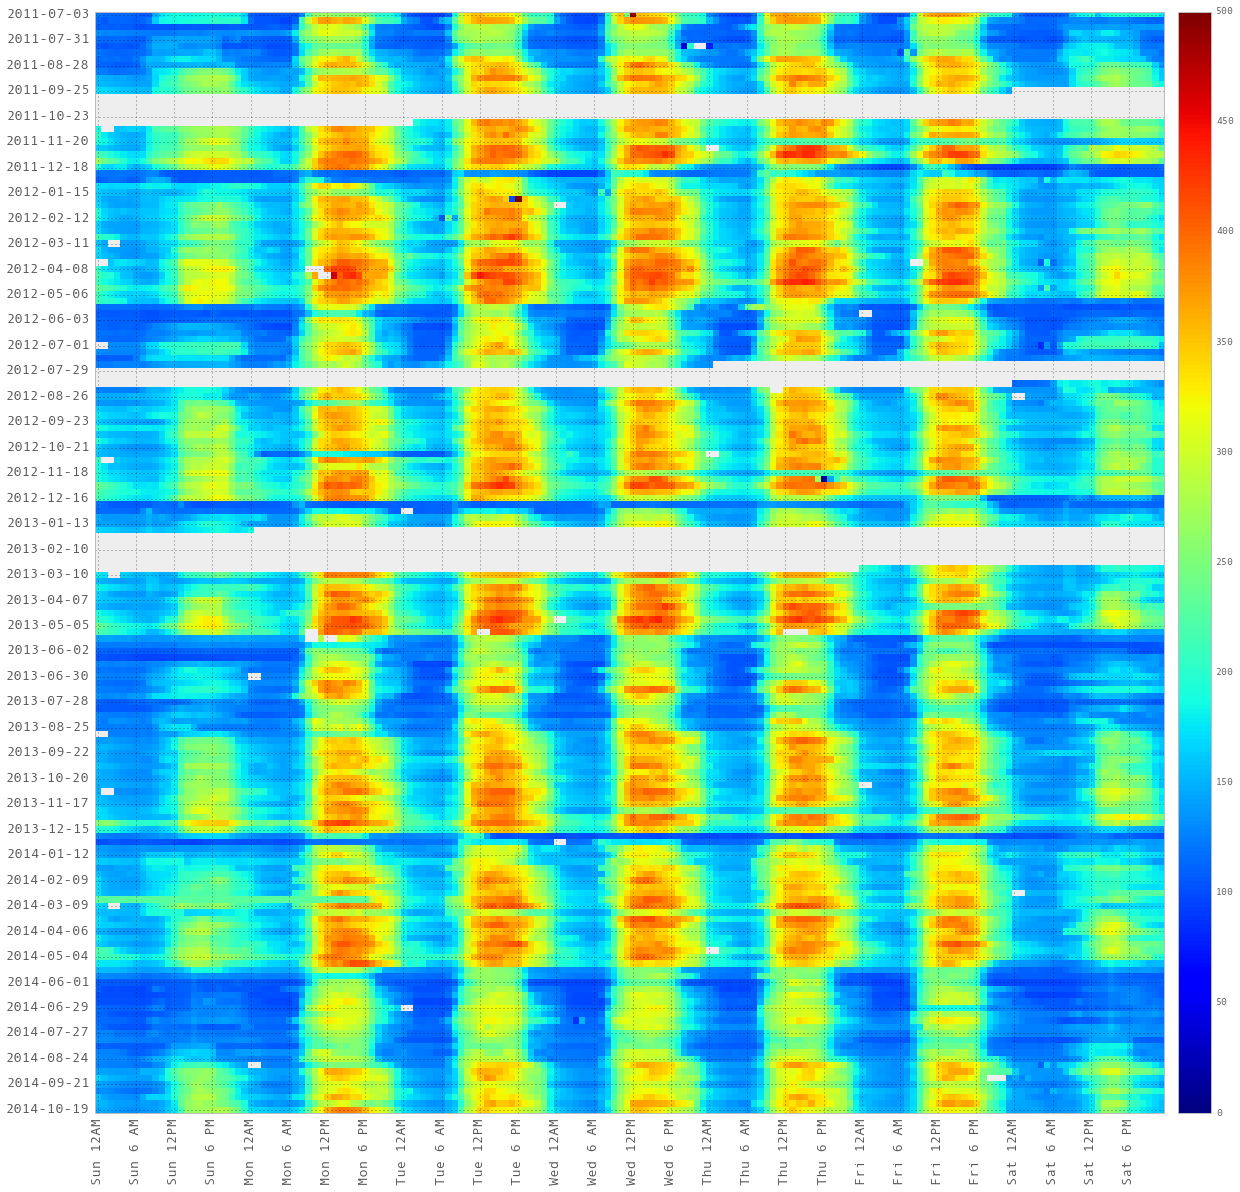

In [40]:
data = hourlyElectricityForVisualization.values
data = data.reshape((len(data)/24/7,24*7))

from mpl_toolkits.axes_grid1 import make_axes_locatable

yTickLabels = pd.DataFrame(data = pd.date_range(start = '2011-07-03', end = '2014-10-25', freq = '4W'), columns=['datetime'])
yTickLabels['date'] = yTickLabels['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))

s1 = ['Sun ', 'Mon ', 'Tue ', 'Wed ', 'Thu ', 'Fri ', 'Sat ']
s2 = ['12AM ', '6 AM', '12PM', '6 PM']
s1 = np.repeat(s1, 4)
s2 = np.tile(s2, 7)
xTickLabels = np.char.add(s1, s2)

fig = plt.figure(figsize=(20,30))
ax = plt.gca()
im = ax.imshow(data, vmin =0, vmax = 500, interpolation='nearest', origin='upper')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ax.set_yticks(range(0,173,4))
ax.set_yticklabels(labels = yTickLabels['date'], fontsize = 14)

ax.set_xticks(range(0,168,6))
ax.set_xticklabels(labels = xTickLabels, fontsize = 14, rotation = 90)

plt.colorbar(im, cax=cax)

> Above is a heapmap of hourly electricity use over three years. The banlk part indicates missing data.

Data length:  172.0  weeks


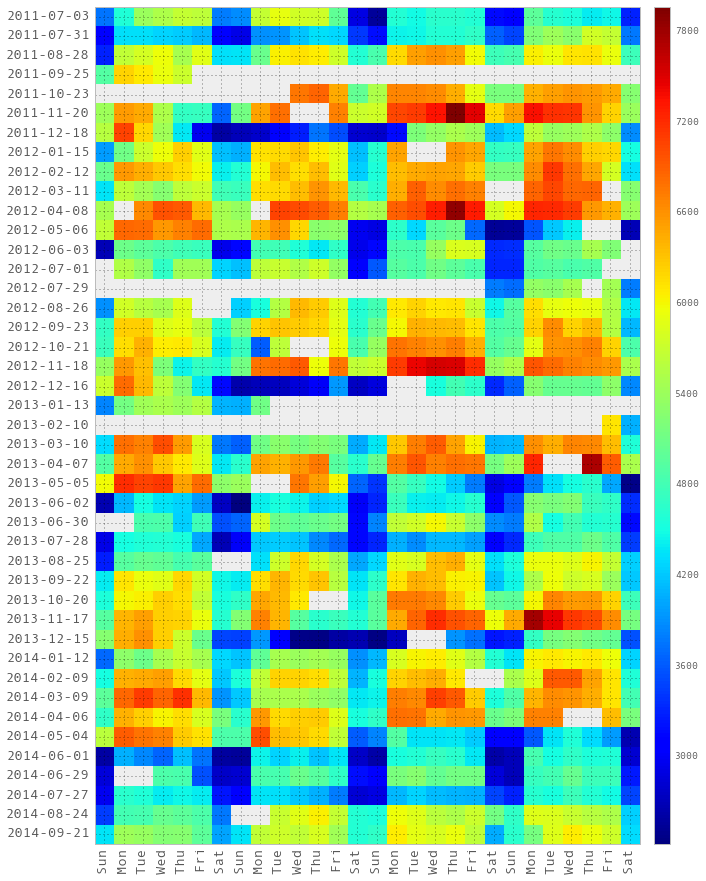

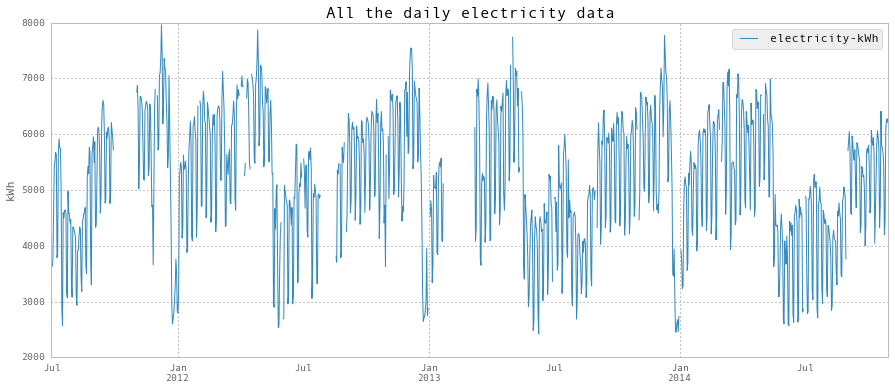

In [41]:
dailyElectricity = pd.read_excel('Data/dailyElectricity.xlsx')

index = (dailyElectricity['startDay'] >= np.datetime64('2011-07-03')) & (dailyElectricity['startDay'] < np.datetime64('2014-10-19'))
dailyElectricityForVisualization = dailyElectricity.loc[index,'electricity-kWh']

print "Data length: ", len(dailyElectricityForVisualization)/7, " weeks"

data = dailyElectricityForVisualization.values
data = data.reshape((len(data)/7/4,7*4))

from mpl_toolkits.axes_grid1 import make_axes_locatable

yTickLabels = pd.DataFrame(data = pd.date_range(start = '2011-07-03', end = '2014-10-25', freq = '4W'), columns=['datetime'])
yTickLabels['date'] = yTickLabels['datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))

s = ['Sun ', 'Mon ', 'Tue ', 'Wed ', 'Thu ', 'Fri ', 'Sat ']
xTickLabels = np.tile(s, 4)

fig = plt.figure(figsize=(14,15))
ax = plt.gca()
im = ax.imshow(data, interpolation='nearest', origin='upper')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ax.set_yticks(range(43))
ax.set_yticklabels(labels = yTickLabels['date'], fontsize = 14)

ax.set_xticks(range(28))
ax.set_xticklabels(labels = xTickLabels, fontsize = 14, rotation = 90)

plt.colorbar(im, cax=cax)
plt.show()

plt.figure()
fig = dailyElectricity.plot(figsize = (15, 6))
fig.set_axis_bgcolor('w')
plt.title('All the daily electricity data', fontsize = 16)
plt.ylabel('kWh')
plt.show()


> Above are a heatmap and a plot of daily electricity use. Blank part indicates missing data.

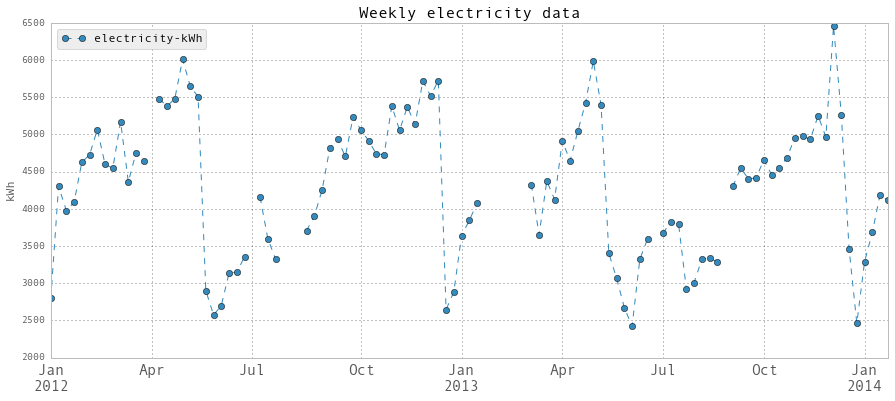

In [42]:
dailyElectricity = pd.read_excel('Data/dailyElectricity.xlsx')
weeklyElectricity = dailyElectricity.asfreq('W', how='sume', normalize=False)

plt.figure()
fig = weeklyElectricity['2012-01':'2014-01'].plot(figsize = (15, 6), fontsize = 15, marker = 'o', linestyle='--')
fig.set_axis_bgcolor('w')
plt.title('Weekly electricity data', fontsize = 16)
plt.ylabel('kWh')
ax = plt.gca()
plt.show()

> Above is a plot of <b>weekly</b> consumption. Broken line part indicates missing data.

It is so obvious the peak consumption is during the finals. And then it suddenly drops. The repeated pattern is very noticeable.

### Findings

* Electricity shows a strong periodical pattern. You can clearly see the difference between day and night, weekdays and weekends. 


* It looks like during each semester, electricity use ramps up toward a peak at finals, perhaps representative of studying patterns. The students are working harder and harder toward finals. Then there is a dip after semesters end, inlcuding Christmas vacation. The electricity consumption is relatively low during January and summer terms, and spring break, when campus can be relatively empty. (Text partially contributed by Steven) 

## Relationship between energy consumption and features

### Main features we considered

In this section, we plot electricity, chilled water and steam consumption (both hourly and daily) against all kinds of features.

In [43]:
# Read in data from Preprocessing results

hourlyElectricityWithFeatures = pd.read_excel('Data/hourlyElectricityWithFeatures.xlsx')
hourlyChilledWaterWithFeatures = pd.read_excel('Data/hourlyChilledWaterWithFeatures.xlsx')
hourlySteamWithFeatures = pd.read_excel('Data/hourlySteamWithFeatures.xlsx')

dailyElectricityWithFeatures = pd.read_excel('Data/dailyElectricityWithFeatures.xlsx')
dailyChilledWaterWithFeatures = pd.read_excel('Data/dailyChilledWaterWithFeatures.xlsx')
dailySteamWithFeatures = pd.read_excel('Data/dailySteamWithFeatures.xlsx')

# An example of Dataframe
dailyChilledWaterWithFeatures.head()

chilledWater-TonDays   startDay     endDay       RH-%       T-C  \
2012-01-01              0.961857 2012-01-01 2012-01-02  76.652174  7.173913   
2012-01-02              0.981725 2012-01-02 2012-01-03  55.958333  5.833333   
2012-01-03              1.003672 2012-01-03 2012-01-04  42.500000 -3.208333   
2012-01-04              1.483192 2012-01-04 2012-01-05  41.541667 -7.083333   
2012-01-05              3.465091 2012-01-05 2012-01-06  46.916667 -0.583333   

               Tdew-C  pressure-mbar  solarRadiation-W/m2  windDirection  \
2012-01-01   3.073913    1004.956522            95.260870     236.086957   
2012-01-02  -2.937500     994.625000            87.333333     253.750000   
2012-01-03 -12.975000    1002.125000            95.708333     302.916667   
2012-01-04 -16.958333    1008.250000            98.750000     286.666667   
2012-01-05  -9.866667    1002.041667            90.750000     258.333333   

            windSpeed-m/s  humidityRatio-kg/kg  coolingDegrees  \
2012-01-01       4.118361             0.004796               0   
2012-01-02       5.914357             0.003415               0   
2012-01-03       6.250005             0.001327               0   
2012-01-04       5.127319             0.000890               0   
2012-01-05       5.162041             0.001746               0   

            heatingDegrees  dehumidification  occupancy  
2012-01-01        7.826087                 0        0.0  
2012-01-02        9.166667                 0        0.3  
2012-01-03       18.208333                 0        0.3  
2012-01-04       22.083333                 0        0.3  
2012-01-05       15.583333                 0        0.3

> Above we print out all the features.

<p><b> coolingDegrees</b>: if T-C - 12 > 0, then = T-C - 12, else = 0. Assume that when outdoor temperature is below 12C, no cooling is needed, which is true for many buildings. This will be useful for daily prediction, because the average of hourly cooling degrees is better than average of hourly temperature.</p>
<p><b> cosHour</b>: $\text{cos}(\text{hourOfDay} \cdot \frac{2\pi}{24})$</p>
<p><b> dehumidification</b>: if humidityRatio - 0.00886 > 0, then = humidityRatio - 0.00886, else = 0. This will be useful for chilled water prediction, especially daily chilled water prediction.</p>
<p><b> heatingDegrees</b>: if 15 - T-C > 0, then = 15 - T-C, else = 0. Assume that when outdoor temperature is above 15C, no heating is needed. This will be useful for daily prediction, because the average of hourly heating degrees is better than average of hourly temperature.</p>
<p><b> occupancy</b>: A number between 0 and 1. 0 indicated no occupants, 1 indicates normal occupancy. This is an estimate based on holidays, weekends and school academic calendar.</p>
<p><b> pressure-mbar</b>: atmospheric pressure</p>
<p><b> RH-% </b>: Relative humidity</p>
<p><b> T-C </b>: Dry-bulb temperature</p>
<p><b> Tdew-C </b>: Dew-point temperature</p>

<b>Humidity ratio</b>: Humidity ratio is calcluated based on T-C, RH and pressure. Humidity ratio is important for chilled water prediction as chilled water is also used to dry the air discharged to rooms. Using humidity ratio will be more efficient and effective than using RH and dew point temperature.

In [44]:
holidays = pd.read_excel('Data/holidays.xlsx')
holidays

startDate    endDate  value
0  2011-07-01 2011-09-06    0.5
1  2011-10-10 2011-10-11    0.6
2  2011-11-24 2011-11-28    0.2
3  2011-12-22 2011-12-24    0.1
4  2011-12-24 2012-01-02    0.0
5  2012-01-02 2012-01-23    0.3
6  2012-03-10 2012-03-19    0.4
7  2012-05-17 2012-09-04    0.5
8  2012-05-28 2012-05-29    0.2
9  2012-10-08 2012-10-09    0.6
10 2012-11-22 2012-11-26    0.2
11 2012-12-22 2012-12-24    0.1
12 2012-12-24 2013-01-02    0.0
13 2013-01-02 2013-01-27    0.3
14 2013-01-20 2013-01-21    0.1
15 2013-03-16 2013-03-25    0.4
16 2013-05-18 2013-09-03    0.5
17 2013-10-14 2013-10-15    0.6
18 2013-11-28 2013-12-02    0.2
19 2013-12-20 2013-12-24    0.1
20 2013-12-24 2014-01-02    0.0
21 2014-01-02 2014-01-26    0.3
22 2014-03-16 2014-03-24    0.4
23 2014-05-17 2014-09-02    0.5

> Above is the setting for "occupancy". Full occupancy is assigned a value of 1.

### Energy Consumption versus Features

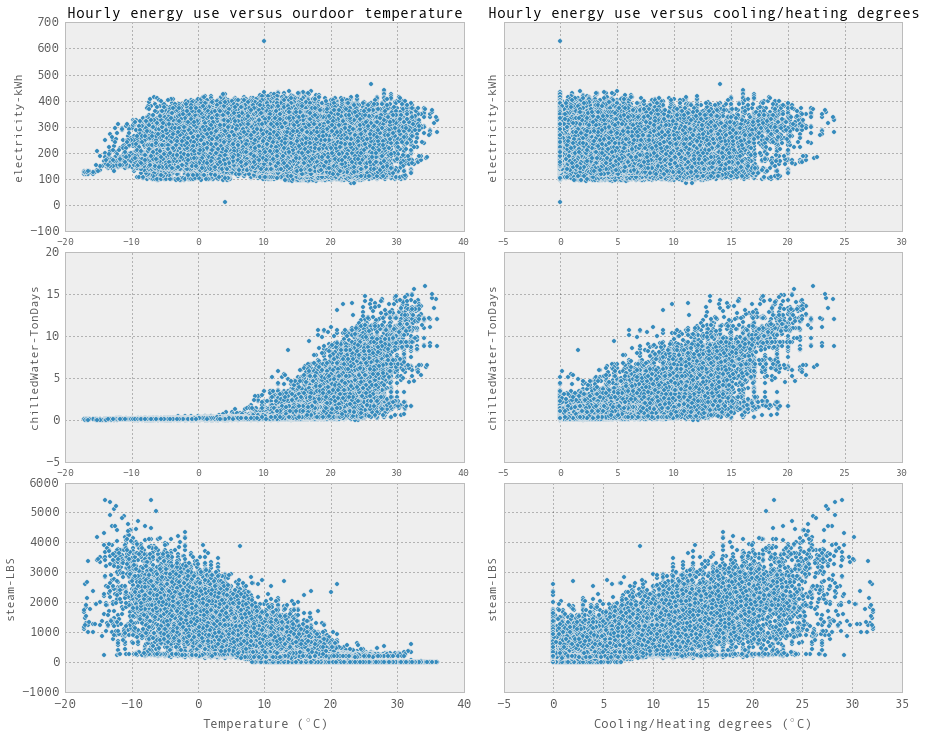

In [45]:
fig, ax = plt.subplots(3, 2, sharey='row', figsize = (15, 12))
fig.subplots_adjust(hspace = 0.1, wspace = 0.1)

hourlyElectricityWithFeatures.plot(kind = 'scatter', x = 'T-C', y = 'electricity-kWh', ax = ax[0,0])
hourlyElectricityWithFeatures.plot(kind = 'scatter', x = 'coolingDegrees', y = 'electricity-kWh', ax = ax[0,1])
hourlyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'T-C', y = 'chilledWater-TonDays', ax = ax[1,0])
hourlyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'coolingDegrees', y = 'chilledWater-TonDays', ax = ax[1,1])
hourlySteamWithFeatures.plot(kind = 'scatter', x = 'T-C', y = 'steam-LBS', ax = ax[2,0])
hourlySteamWithFeatures.plot(kind = 'scatter', x = 'heatingDegrees', y = 'steam-LBS', ax = ax[2,1])

for i in range(3):    
    ax[i,0].tick_params(which=u'major', reset=False, axis = 'y', labelsize = 13)
    #ax[i,0].set_axis_bgcolor('w')

for i in range(2):    
    ax[2,i].tick_params(which=u'major', reset=False, axis = 'x', labelsize = 13)

ax[2,0].set_xlabel(r'Temperature ($^\circ$C)', fontsize = 13)
ax[2,0].set_xlim([-20,40])
ax[0,0].set_title('Hourly energy use versus ourdoor temperature', fontsize = 15)

ax[2,1].set_xlabel(r'Cooling/Heating degrees ($^\circ$C)', fontsize = 13)
#ax[2,1].set_xlim([0,30])
ax[0,1].set_title('Hourly energy use versus cooling/heating degrees', fontsize = 15)

plt.show()

> Chilled water and steam are strongly co-related with temperature. However, using only outdoor temperature or cooling/heating degrees to predict hourly chilled water and steam is not suffient.

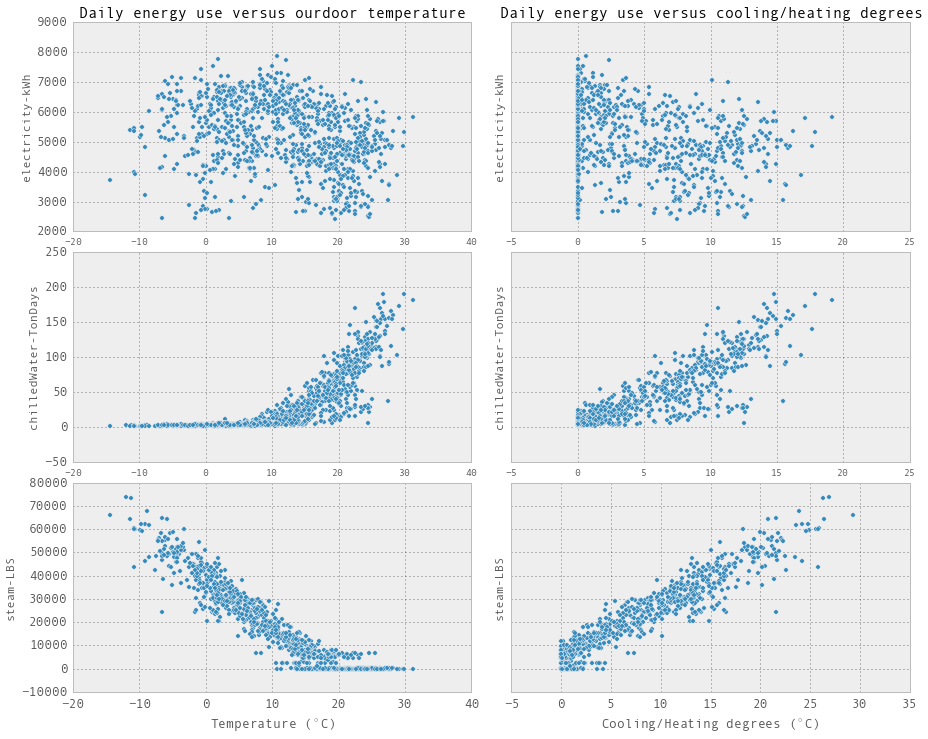

In [46]:
fig, ax = plt.subplots(3, 2, sharey='row', figsize = (15, 12))
fig.subplots_adjust(hspace = 0.1, wspace = 0.1)

dailyElectricityWithFeatures.plot(kind = 'scatter', x = 'T-C', y = 'electricity-kWh', ax = ax[0,0])
dailyElectricityWithFeatures.plot(kind = 'scatter', x = 'coolingDegrees', y = 'electricity-kWh', ax = ax[0,1])
dailyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'T-C', y = 'chilledWater-TonDays', ax = ax[1,0])
dailyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'coolingDegrees', y = 'chilledWater-TonDays', ax = ax[1,1])
dailySteamWithFeatures.plot(kind = 'scatter', x = 'T-C', y = 'steam-LBS', ax = ax[2,0])
dailySteamWithFeatures.plot(kind = 'scatter', x = 'heatingDegrees', y = 'steam-LBS', ax = ax[2,1])

for i in range(3):    
    ax[i,0].tick_params(which=u'major', reset=False, axis = 'y', labelsize = 13)
    #ax[i,0].set_axis_bgcolor('w')

for i in range(2):    
    ax[2,i].tick_params(which=u'major', reset=False, axis = 'x', labelsize = 13)

ax[2,0].set_xlabel(r'Temperature ($^\circ$C)', fontsize = 13)
ax[2,0].set_xlim([-20,40])
ax[0,0].set_title('Daily energy use versus ourdoor temperature', fontsize = 15)

ax[2,1].set_xlabel(r'Cooling/Heating degrees ($^\circ$C)', fontsize = 13)
#ax[2,1].set_xlim([0,30])
ax[0,1].set_title('Daily energy use versus cooling/heating degrees', fontsize = 15)

plt.show()

> Daily chilled water and steam has a strong linear relationship with outdoor temperature. If using cooling/heating degrees instead of T-C, one mihgt avoid stepwise linear regression.

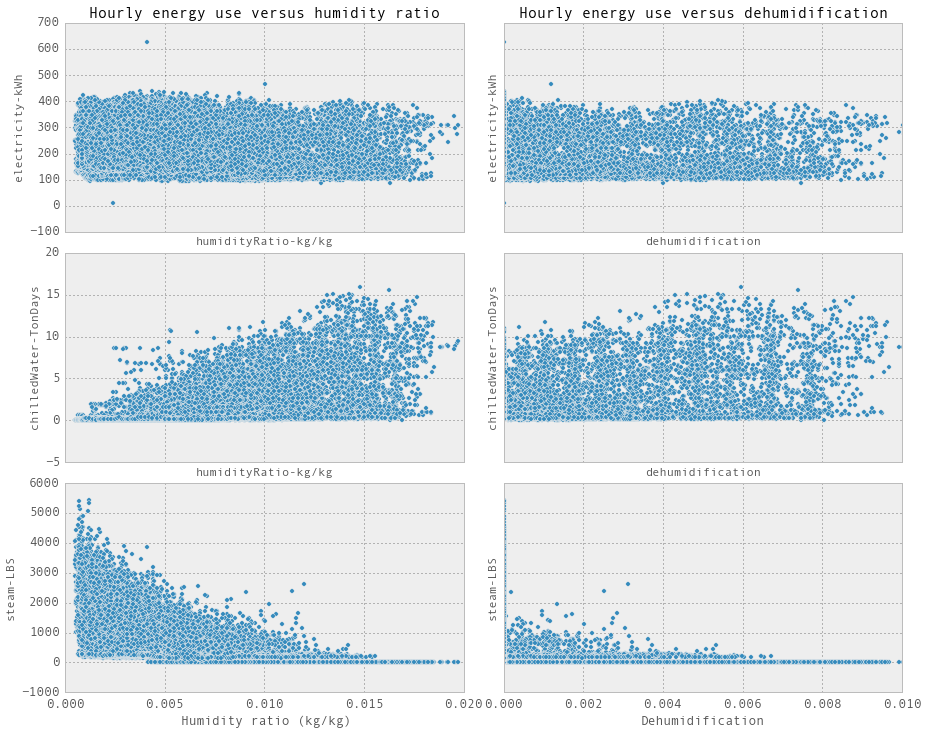

In [47]:
fig, ax = plt.subplots(3, 2, sharex = 'col', sharey='row', figsize = (15, 12))
fig.subplots_adjust(hspace = 0.1, wspace = 0.1)

hourlyElectricityWithFeatures.plot(kind = 'scatter', x = 'humidityRatio-kg/kg', y = 'electricity-kWh', ax = ax[0,0])
hourlyElectricityWithFeatures.plot(kind = 'scatter', x = 'dehumidification', y = 'electricity-kWh', ax = ax[0,1])
hourlyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'humidityRatio-kg/kg', y = 'chilledWater-TonDays', ax = ax[1,0])
hourlyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'dehumidification', y = 'chilledWater-TonDays', ax = ax[1,1])
hourlySteamWithFeatures.plot(kind = 'scatter', x = 'humidityRatio-kg/kg', y = 'steam-LBS', ax = ax[2,0])
hourlySteamWithFeatures.plot(kind = 'scatter', x = 'dehumidification', y = 'steam-LBS', ax = ax[2,1])

for i in range(3):    
    ax[i,0].tick_params(which=u'major', reset=False, axis = 'y', labelsize = 13)
    #ax[i,0].set_axis_bgcolor('w')

for i in range(2):    
    ax[2,i].tick_params(which=u'major', reset=False, axis = 'x', labelsize = 13)

ax[2,0].set_xlabel(r'Humidity ratio (kg/kg)', fontsize = 13)
ax[2,0].set_xlim([0,0.02])
ax[0,0].set_title('Hourly energy use versus humidity ratio', fontsize = 15)

ax[2,1].set_xlabel(r'Dehumidification', fontsize = 13)
ax[2,1].set_xlim([0,0.01])
ax[0,1].set_title('Hourly energy use versus dehumidification', fontsize = 15)

plt.show()

> Humidity ratio definitely will help predict chilled water consumption and it is better than RH and Tdrew.

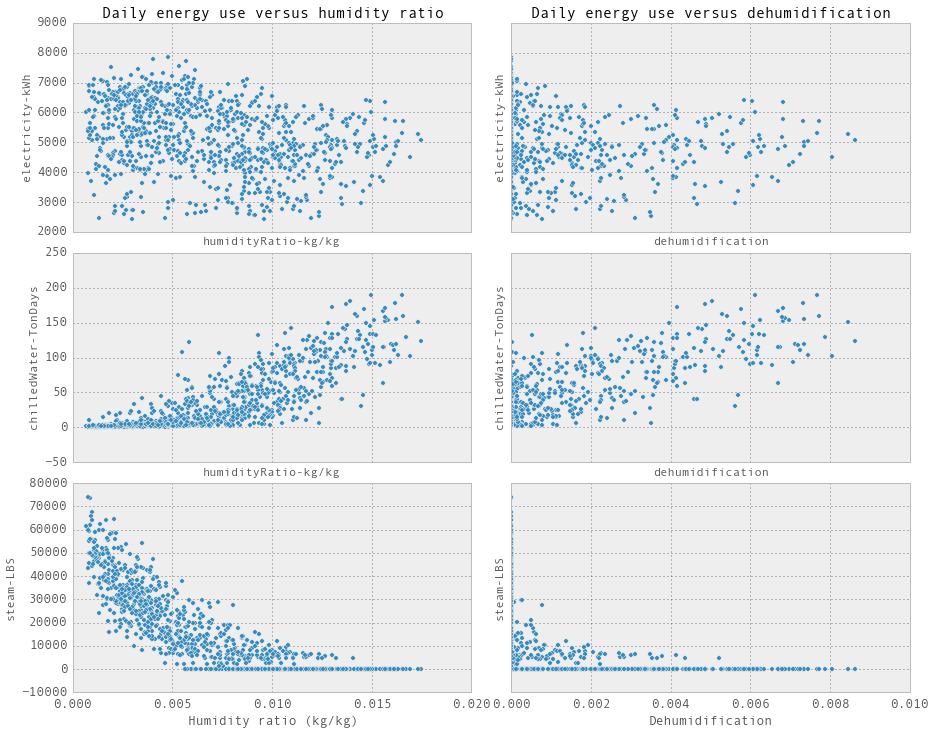

In [48]:
fig, ax = plt.subplots(3, 2, sharex = 'col', sharey='row', figsize = (15, 12))
fig.subplots_adjust(hspace = 0.1, wspace = 0.1)

dailyElectricityWithFeatures.plot(kind = 'scatter', x = 'humidityRatio-kg/kg', y = 'electricity-kWh', ax = ax[0,0])
dailyElectricityWithFeatures.plot(kind = 'scatter', x = 'dehumidification', y = 'electricity-kWh', ax = ax[0,1])
dailyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'humidityRatio-kg/kg', y = 'chilledWater-TonDays', ax = ax[1,0])
dailyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'dehumidification', y = 'chilledWater-TonDays', ax = ax[1,1])
dailySteamWithFeatures.plot(kind = 'scatter', x = 'humidityRatio-kg/kg', y = 'steam-LBS', ax = ax[2,0])
dailySteamWithFeatures.plot(kind = 'scatter', x = 'dehumidification', y = 'steam-LBS', ax = ax[2,1])

for i in range(3):    
    ax[i,0].tick_params(which=u'major', reset=False, axis = 'y', labelsize = 13)
    #ax[i,0].set_axis_bgcolor('w')

for i in range(2):    
    ax[2,i].tick_params(which=u'major', reset=False, axis = 'x', labelsize = 13)

ax[2,0].set_xlabel(r'Humidity ratio (kg/kg)', fontsize = 13)
ax[2,0].set_xlim([0,0.02])
ax[0,0].set_title('Daily energy use versus humidity ratio', fontsize = 15)

ax[2,1].set_xlabel(r'Dehumidification', fontsize = 13)
ax[2,1].set_xlim([0,0.01])
ax[0,1].set_title('Daily energy use versus dehumidification', fontsize = 15)

plt.show()

> Dehumidification is designed for chilled water prediction, not steam.

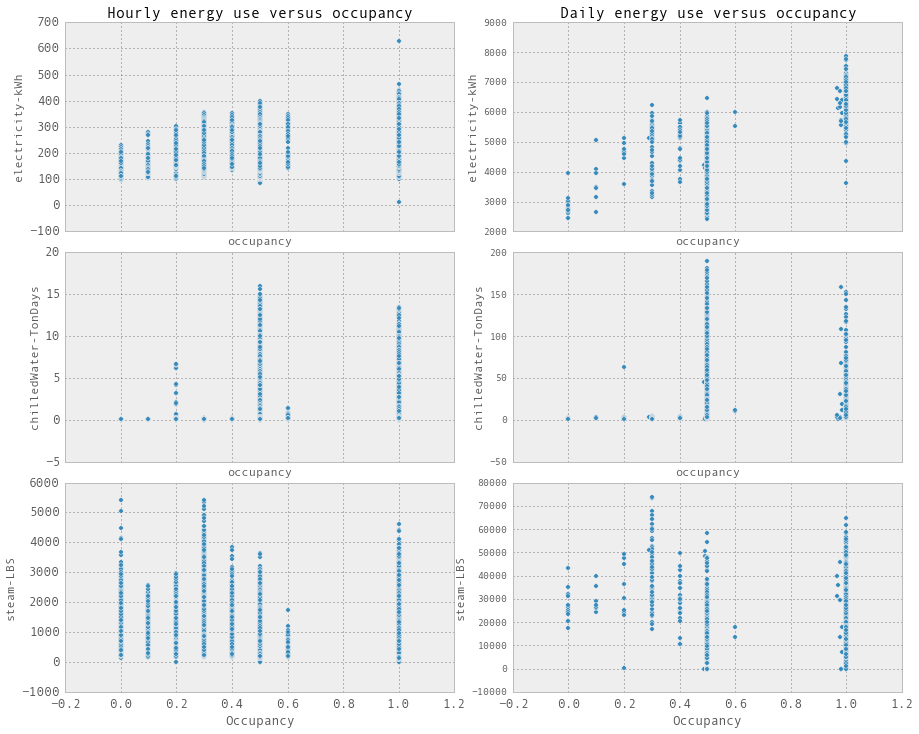

In [49]:
fig, ax = plt.subplots(3, 2, sharex = 'col', figsize = (15, 12))
fig.subplots_adjust(hspace = 0.1, wspace = 0.15)

hourlyElectricityWithFeatures.plot(kind = 'scatter', x = 'occupancy', y = 'electricity-kWh', ax = ax[0,0])
dailyElectricityWithFeatures.plot(kind = 'scatter', x = 'occupancy', y = 'electricity-kWh', ax = ax[0,1])
hourlyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'occupancy', y = 'chilledWater-TonDays', ax = ax[1,0])
dailyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'occupancy', y = 'chilledWater-TonDays', ax = ax[1,1])
hourlySteamWithFeatures.plot(kind = 'scatter', x = 'occupancy', y = 'steam-LBS', ax = ax[2,0])
dailySteamWithFeatures.plot(kind = 'scatter', x = 'occupancy', y = 'steam-LBS', ax = ax[2,1])

for i in range(3):    
    ax[i,0].tick_params(which=u'major', reset=False, axis = 'y', labelsize = 13)
    #ax[i,0].set_axis_bgcolor('w')

for i in range(2):    
    ax[2,i].tick_params(which=u'major', reset=False, axis = 'x', labelsize = 13)

ax[2,0].set_xlabel(r'Occupancy', fontsize = 13)
#ax[2,0].set_xlim([0,0.02])
ax[0,0].set_title('Hourly energy use versus occupancy', fontsize = 15)

ax[2,1].set_xlabel(r'Occupancy', fontsize = 13)

#ax[2,1].set_xlim([0,0.01])
ax[0,1].set_title('Daily energy use versus occupancy', fontsize = 15)

plt.show()

> Occupancy is derived from academic calendar, holidays and weekends. Basiaclly, we just assign a lower value to holidays, weekends and summer. cosHour, occupancy might help, might not, since they are just estimation of occupancy.

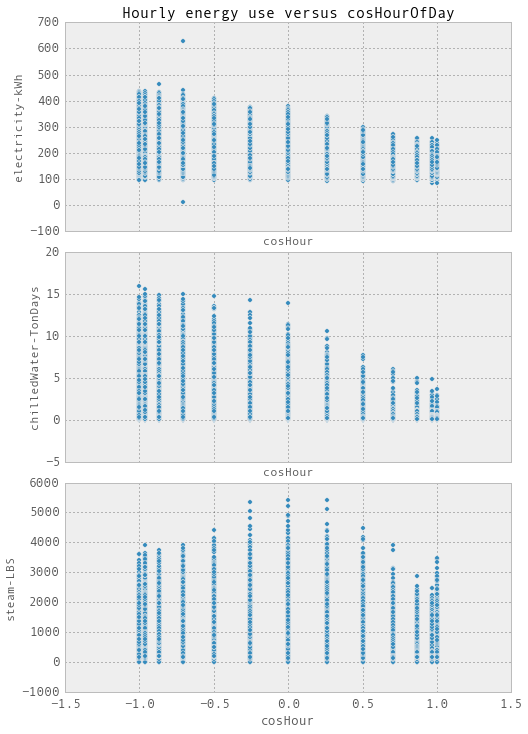

In [50]:
fig, ax = plt.subplots(3, 1, sharex = 'col', figsize = (8, 12))
fig.subplots_adjust(hspace = 0.1, wspace = 0.15)

hourlyElectricityWithFeatures.plot(kind = 'scatter', x = 'cosHour', y = 'electricity-kWh', ax = ax[0])
hourlyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'cosHour', y = 'chilledWater-TonDays', ax = ax[1])
hourlySteamWithFeatures.plot(kind = 'scatter', x = 'cosHour', y = 'steam-LBS', ax = ax[2])

for i in range(3):    
    ax[i].tick_params(which=u'major', reset=False, axis = 'y', labelsize = 13)
    #ax[i,0].set_axis_bgcolor('w')

ax[2].tick_params(which=u'major', reset=False, axis = 'x', labelsize = 13)

ax[2].set_xlabel(r'cosHour', fontsize = 13)
#ax[2,0].set_xlim([0,0.02])
ax[0].set_title('Hourly energy use versus cosHourOfDay', fontsize = 15)

plt.show()

> There is some strend between energy use and cosHour.

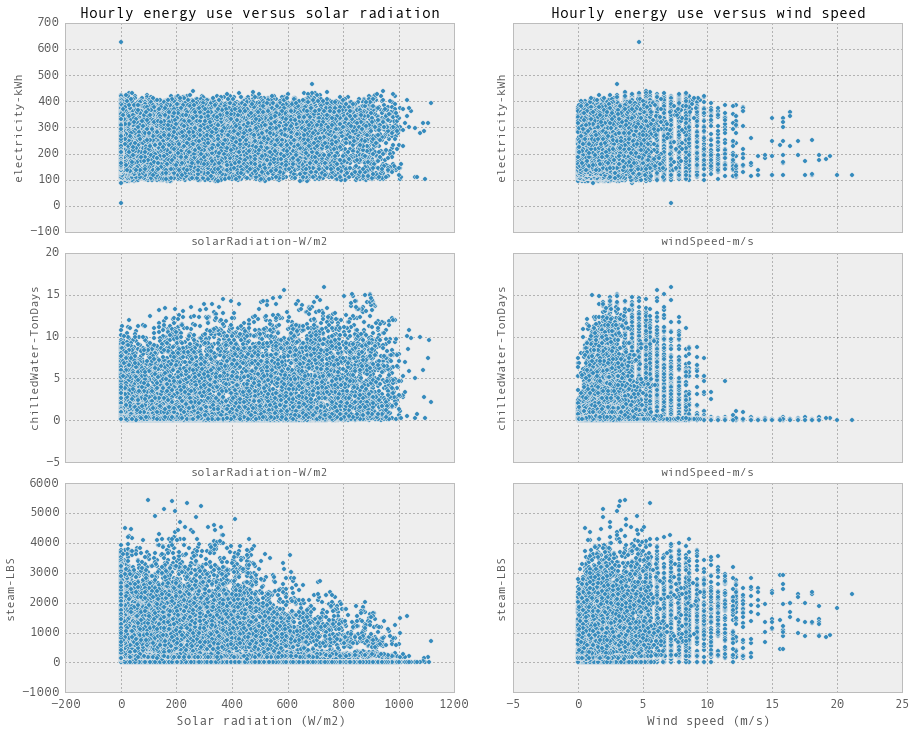

In [51]:
fig, ax = plt.subplots(3, 2, sharex = 'col', sharey = 'row', figsize = (15, 12))
fig.subplots_adjust(hspace = 0.1, wspace = 0.15)

hourlyElectricityWithFeatures.plot(kind = 'scatter', x = 'solarRadiation-W/m2', y = 'electricity-kWh', ax = ax[0,0])
hourlyElectricityWithFeatures.plot(kind = 'scatter', x = 'windSpeed-m/s', y = 'electricity-kWh', ax = ax[0,1])
hourlyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'solarRadiation-W/m2', y = 'chilledWater-TonDays', ax = ax[1,0])
hourlyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'windSpeed-m/s', y = 'chilledWater-TonDays', ax = ax[1,1])
hourlySteamWithFeatures.plot(kind = 'scatter', x = 'solarRadiation-W/m2', y = 'steam-LBS', ax = ax[2,0])
hourlySteamWithFeatures.plot(kind = 'scatter', x = 'windSpeed-m/s', y = 'steam-LBS', ax = ax[2,1])

for i in range(3):    
    ax[i,0].tick_params(which=u'major', reset=False, axis = 'y', labelsize = 13)
    #ax[i,0].set_axis_bgcolor('w')

for i in range(2):    
    ax[2,i].tick_params(which=u'major', reset=False, axis = 'x', labelsize = 13)

ax[2,0].set_xlabel(r'Solar radiation (W/m2)', fontsize = 13)
#ax[2,0].set_xlim([0,0.02])
ax[0,0].set_title('Hourly energy use versus solar radiation', fontsize = 15)

ax[2,1].set_xlabel(r'Wind speed (m/s)', fontsize = 13)

#ax[2,1].set_xlim([0,0.01])
ax[0,1].set_title('Hourly energy use versus wind speed', fontsize = 15)

plt.show()

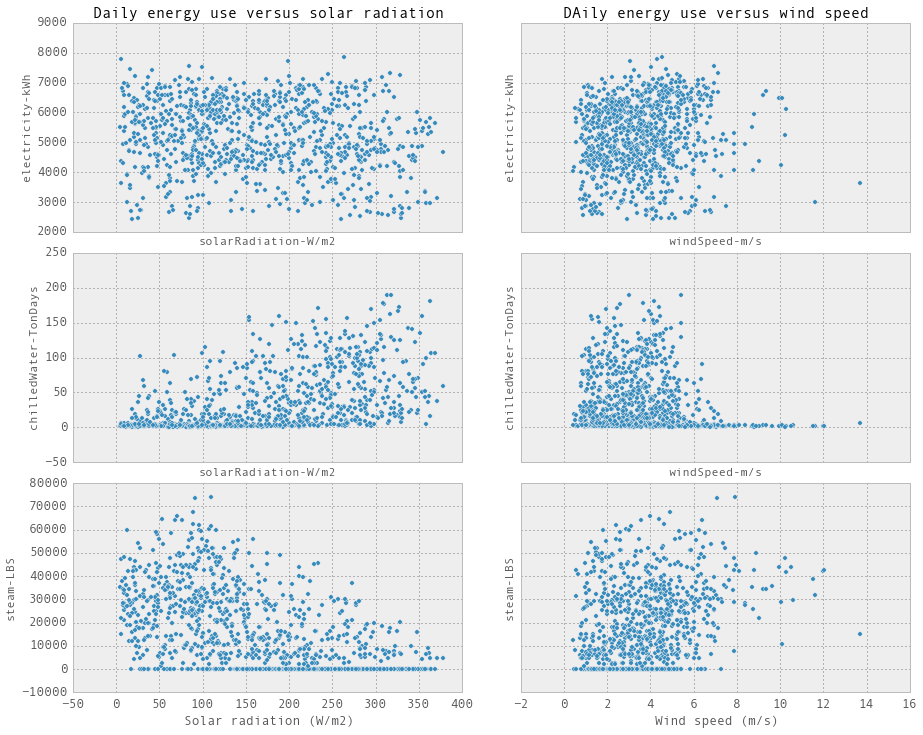

In [52]:
fig, ax = plt.subplots(3, 2, sharex = 'col', sharey = 'row', figsize = (15, 12))
fig.subplots_adjust(hspace = 0.1, wspace = 0.15)

dailyElectricityWithFeatures.plot(kind = 'scatter', x = 'solarRadiation-W/m2', y = 'electricity-kWh', ax = ax[0,0])
dailyElectricityWithFeatures.plot(kind = 'scatter', x = 'windSpeed-m/s', y = 'electricity-kWh', ax = ax[0,1])
dailyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'solarRadiation-W/m2', y = 'chilledWater-TonDays', ax = ax[1,0])
dailyChilledWaterWithFeatures.plot(kind = 'scatter', x = 'windSpeed-m/s', y = 'chilledWater-TonDays', ax = ax[1,1])
dailySteamWithFeatures.plot(kind = 'scatter', x = 'solarRadiation-W/m2', y = 'steam-LBS', ax = ax[2,0])
dailySteamWithFeatures.plot(kind = 'scatter', x = 'windSpeed-m/s', y = 'steam-LBS', ax = ax[2,1])

for i in range(3):    
    ax[i,0].tick_params(which=u'major', reset=False, axis = 'y', labelsize = 13)
    #ax[i,0].set_axis_bgcolor('w')

for i in range(2):    
    ax[2,i].tick_params(which=u'major', reset=False, axis = 'x', labelsize = 13)

ax[2,0].set_xlabel(r'Solar radiation (W/m2)', fontsize = 13)
#ax[2,0].set_xlim([0,0.02])
ax[0,0].set_title('Daily energy use versus solar radiation', fontsize = 15)

ax[2,1].set_xlabel(r'Wind speed (m/s)', fontsize = 13)

#ax[2,1].set_xlim([0,0.01])
ax[0,1].set_title('DAily energy use versus wind speed', fontsize = 15)

plt.show()

> Solar radiation and wind speed are not that important and it is correlated with temperature.

### Findings

* Electricity is not co-related with weather data (temperature). The idea of using weather information to predict electricity will NOT work. I think it mostly depends on time/occupancy. But we can still do some pattern exploration to figure out day/night, weekday/weekend, school day/holiday electricity consumption pattern. Actually, we should have noticed that from monthly data.


* Chilled water and steam are strongly correlated with temperature and humidity. Daily chilled water and steam consumption have a good linear relationship with cooling and heating degrees. Therefore, simple linear regression might already be accurate enough. 



* Although chilled water and steam consumption are strongly correlated with weather, using with weather information to predict hourly chilled water and steam is not suffient according to the plots above. This is because operation schedule affects hourly energy consumption. Occupancy and operation schedule must be included in hourly chilled water and steam prediction.


* Humidity ratio definitely will help predict chilled water consumption and it is better than RH and Tdrew.


* Cooling and heating degrees will help predict daily chilled water and steam. If using cooling/heating degrees instead of T-C, one mihgt avoid stepwise linear regression.


* Occupancy is derived from academic calendar, holidays and weekends. Basiaclly, we just assign a lower value to holidays, weekends and summer. cosHour, occupancy might help, might not, since they are just estimation of occupancy.